## Setup libs

In [1]:
import importlib
from tools import brikasutils as bu
from tools import shared_utils as utils 
from tools.shared_utils import systemMsg, userMsg, assistantMsg
from tools import survey, persona
[importlib.reload(m) for m in [persona, survey, utils, bu]]

import ollama, os, re, time, json
import numpy as np
from numpy.linalg import norm
import pandas as pd
from typing import List
from openai import OpenAI

# **Analysis**

### Batch analysis

In [1]:
def see_if_column_valid(column_name, df, msg="Verification failed for"):
    dff = df[df[column_name].isna()]
    dfff = dff.groupby("sim_signature").apply(lambda x: x[x['run_number'] == 1], include_groups=False)
    print(f"{msg}: {len(dff)} ({len(dfff)} unique)")
    return dfff

MOST_IMPORTANT_COLUMNS = ['sim_signature', 'run_number', "model", "survey_type", "base_sim_signature", "SUBJECT", 'CTX_limit', "retrieval method"]

In [2]:
# Index all simulation files
SIMULATIONS_DIR = "analysis/sims-final-2"

sim_runs = []
for root, dirs, files in os.walk(SIMULATIONS_DIR):
    for file in files:
        if file.split(".")[1] != "json":
            print(f"Invalid file (all must be json) {sim_run['path']}")

        sim_run = {}
        sim_run["SIMULATION_ID"] = file.split(".")[0]
        sim_run["path"] = os.path.join(root, file)
        with open(sim_run["path"], 'r') as f:
            sim = json.load(f)
        sim_run.update(sim["info"]["info"])
        sim_run.update(sim["info"]["settings"])
        sim_runs.append(sim_run)

df = pd.DataFrame(sim_runs)
df = df.dropna(axis=1, how='all')
print(f"Loaded {len(df)} simulation files")

Loaded 234 simulation files


### Infer/Get Needed Data

In [3]:
def infer_survey_type(row):
    if "survey_type" in row and not pd.isna(row["survey_type"]):
        if row["survey_type"] == "KanoSurvey":
            return "KanoSurvey"
        elif row["survey_type"] == "PersonalitySurvey":
            return "PersonalitySurvey"
        else:
            print("Unknown survey type" + row["survey_type"])

    if "prompt_count" in row and not pd.isna(row["prompt_count"]):
        if row["prompt_count"] == 50:
            return "PersonalitySurvey"
        elif row["prompt_count"] == 40:
            return "KanoSurvey"
        else:
            print("Unknown prompt count" + row["prompt_count"])

    return None

df["survey_type"] = df.apply(infer_survey_type, axis=1) 
df["survey_type"].value_counts()

# extract_run_number
def extract_run_number(sim_id):
    try:
        parts = sim_id.rsplit('_', 1)  # Attempt to split by the last underscore
        if len(parts) == 2:  # Check if the split was successful
            return pd.Series([parts[0], int(parts[-1])])
        else:
            print(f"Error while processing {sim_id}")
            return pd.Series([pd.NA, pd.NA])  # Return None for last_number if split fails
         
    except Exception as e:  # Generic exception handling
        print(f"Error while processing {sim_id}")
        return pd.Series([pd.NA, pd.NA])

df[['sim_signature', 'run_number']] = df['SIMULATION_ID'].apply(extract_run_number)

In [4]:
# infer_if_simulation_is_base
def infer_if_simulation_is_base(row):
    if row["sim_signature"][:4] == "base":
        return True
    return False
    
df["is_base"] = df.apply(infer_if_simulation_is_base, axis=1)

# Below: Vanity Print
dff = df[df["is_base"] == True]
dff = dff.sort_values(by=['sim_signature', 'run_number'])
dff = dff.dropna(axis=1, how='all')
dfff = dff.groupby("sim_signature").apply(lambda x: x[x['run_number'] == 1], include_groups=False)
print(f"Found {len(dff)} ({len(dfff)} unique) base simulations")

Found 18 (6 unique) base simulations


In [51]:
# Preview base
dfff

,,SIMULATION_ID,path,date,CHUNK_SIZE,OVERLAP_SIZE,CTX_limit,EMBED_MODEL,prompt method,retrieval method,RETRIEVAL_PROMPT,...,average_prompt_tokens,total_all_prompt_tokens,prompt_tokens_min,prompt_tokens_max,avg_tokens_in_prompt,model,timeout,survey_type,run_number,is_base
sim_signature,,,,,,,,,,,,,,,,,,,,,,
base-kano-29_llama3-70b_V7,109,base-kano-29_llama3-70b_V7_1,analysis/sims-final-2\base-kano-29_llama3-70b_...,2024-05-06_133115,75,3,31000,nomic-embed-text,IMPERSONATE,base,video game features,...,109,4345,104,117,109,llama3-70b,300,KanoSurvey,1,True
base-kano-29_llama3-8b_V7,112,base-kano-29_llama3-8b_V7_1,analysis/sims-final-2\base-kano-29_llama3-8b_V...,2024-05-06_111147,75,3,31000,nomic-embed-text,IMPERSONATE,base,video game features,...,109,4345,104,117,109,llama3-8b,300,KanoSurvey,1,True
base-kano-29_mixtral-8x22b_V7,115,base-kano-29_mixtral-8x22b_V7_1,analysis/sims-final-2\base-kano-29_mixtral-8x2...,2024-05-06_111021,75,3,31000,nomic-embed-text,IMPERSONATE,base,video game features,...,109,4345,104,117,109,mixtral-8x22b,300,KanoSurvey,1,True
base-pers-29_llama3-70b_V7,118,base-pers-29_llama3-70b_V7_1,analysis/sims-final-2\base-pers-29_llama3-70b_...,2024-05-06_141229,75,3,31000,nomic-embed-text,IMPERSONATE,base,openess conciousness extrovert aggreableness n...,...,97,4831,94,102,97,llama3-70b,300,PersonalitySurvey,1,True
base-pers-29_llama3-8b_V7,121,base-pers-29_llama3-8b_V7_1,analysis/sims-final-2\base-pers-29_llama3-8b_V...,2024-05-06_111124,75,3,31000,nomic-embed-text,IMPERSONATE,base,openess conciousness extrovert aggreableness n...,...,97,4831,94,102,97,llama3-8b,300,PersonalitySurvey,1,True
base-pers-29_mixtral-8x22b_V7,124,base-pers-29_mixtral-8x22b_V7_1,analysis/sims-final-2\base-pers-29_mixtral-8x2...,2024-05-06_062133,75,3,31000,nomic-embed-text,IMPERSONATE,base,openess conciousness extrovert aggreableness n...,...,97,4831,94,102,97,mixtral-8x22b,300,PersonalitySurvey,1,True


In [5]:
# Map simulations to their base
def map_simulation_to_base(row):
    if row["is_base"] == True:
        return "(base)"
    if row["survey_type"] == "KanoSurvey" and row["model"] == "gpt-3.5-turbo":
        return "base_kano_v2_gpt35"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "gpt-3.5-turbo":
        return "base_personality_v2_gpt35"

    if row["survey_type"] == "KanoSurvey" and row["model"] == "llama3-70b":
        return "base-kano-29_llama3-70b_V7"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "llama3-70b":
        return "base-pers-29_llama3-70b_V7"
    
    if row["survey_type"] == "KanoSurvey" and row["model"] == "llama3-8b":
        return "base-kano-29_llama3-8b_V7"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "llama3-8b":
        return "base-pers-29_llama3-8b_V7"
    
    if row["survey_type"] == "KanoSurvey" and row["model"] == "mixtral-8x22b":
        return "base-kano-29_mixtral-8x22b_V7"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "mixtral-8x22b":
        return "base-pers-29_mixtral-8x22b_V7"
    
    return pd.NA
    
df["base_sim_signature"] = df.apply(map_simulation_to_base, axis=1)
dff = see_if_column_valid("base_sim_signature", df, "Missing mappings")
if len(dff) == 0:
    print("All mappings are valid")
else:
    print("Not all mappings are valid. See the missing mappings below")
    display(dff)

def infer_subject(row):
    if row["is_base"]:
        return "(base)"
    if "SUBJECT" in row and pd.notna(row["SUBJECT"]):
        if row["SUBJECT"] == "airidas" or row["SUBJECT"] == "Airidas" or row["SUBJECT"] == "airi":
            return "airidas"
        if row["SUBJECT"] == "elias" or row["SUBJECT"] == "eli":
            return "elias"
        print(f"Unknown subject: {row['SUBJECT']}")
        return pd.NA
    if "subject" in row and pd.notna(row["subject"]):
        if row["subject"] == "airidas" or row["subject"] == "Airidas" or row["subject"] == "airi":
            return "airidas"
        if row["subject"] == "elias" or row["subject"] == "eli":
            return "elias"
        print(f"Unknown subject: {row['subject']}")
        return pd.NA
    if row["sim_signature"][:4] == "airi":
        return "airidas"
    if row["sim_signature"][:3] == "eli":
        return "elias"
    return pd.NA

df["SUBJECT"] = df.apply(infer_subject, axis=1)
dff = see_if_column_valid("SUBJECT", df, "Missing subjects")
if len(dff) == 0:
    print("All subjects are valid")
else:
    display(dff)

df = utils.bring_to_front_important_columns(df, MOST_IMPORTANT_COLUMNS)


Missing mappings: 0 (0 unique)
All mappings are valid
Missing subjects: 0 (0 unique)
All subjects are valid


### Compute Scores

#### Setup

In [6]:
def get_surv_from_info(row):
    if row["survey_type"] == "KanoSurvey":
        return survey.KanoSurvey()
    elif row["survey_type"] == "PersonalitySurvey":
        return survey.PersonalitySurvey()
    else:
        raise Exception("Unknown survey type: " + row["survey_type"])

all_possible_asnwers = ["I LIKE IT", "I EXPECT IT", "I AM NEUTRAL", "I CAN TOLERATE IT", "I DISLIKE IT", "SOMEWHAT DISAGREE", "DISAGREE", "NEUTRAL", "SOMEWHAT AGREE", "AGREE"]
def extract_possible_answer(value):
    for phrase in all_possible_asnwers:
        pattern = r'(?i)' + re.escape(phrase)
        match = re.search(pattern, value)
        if match:
            # if value != phrase:
            #     er.append([value, phrase])  
            return match.group()
    return value  # Return the original value if no possible answer is found

############ Invalid Answers ##################
def get_invalid_answers(value):
    if pd.isna(value):
        return ""
    elif value == "NaN":
        return ""
    elif value in all_possible_asnwers:
        return ""
    else:
        return value

def clean_simulation_QA(df) -> pd.DataFrame:
    df['answer'] = df['answer'].apply(lambda x: x.strip())
    for substr in utils.BLACKLIST_ANSWER_SUBSTRINGS:
        df['answer'] = df['answer'].apply(lambda x: re.sub(substr, "", x))
    df['answer'] = df['answer'].str.upper()
    df['answer'] = df['answer'].apply(extract_possible_answer)

    REMAP_MISSING_E = {"AGRE": "AGREE", "SOMEWHAT AGRE": "SOMEWHAT AGREE", "SOMEWHAT DISAGRE": "SOMEWHAT DISAGREE", "DISAGRE": "DISAGREE", "I DON'T LIKE IT": "I DISLIKE IT"}
    df.iloc[:, 1:] = df.iloc[:, 1:].map(lambda x: REMAP_MISSING_E.get(x, x))

    PARTIAL_MATCH_REMAP = {"SOMEWHAT AG":"SOMEWHAT AGREE" }
    df["answer"] = df["answer"].apply(
        lambda answer: next((value for key, value in PARTIAL_MATCH_REMAP.items() if key in answer), answer)
    )

    # Update isValid
    df['isValid'] = df['answer'].apply(lambda x: x in all_possible_asnwers)

    # if all values in isValid is true, drop the column, else print a message
    if not df['isValid'].all():
        print("Warning, some answers were not valid. See df['isValid']")      

    return df

# Proces simulation output
def add_airidas_and_elias_answers(df, surv) -> pd.DataFrame:
    # Add airidas and elias answers
    air = surv.test_answers["airidas"]
    eli = surv.test_answers["elias"]

    # Sanity Check
    if len(air) != len(df):
        raise Exception(f"Survey and DF length mismatch {len(air)} != {len(df)}. Suvey type: {str(type(surv))}")

    df.insert(2, "airidas", air[:len(df)])
    df.insert(3, "elias", eli[:len(df)])

    # Convert to uppercase
    if isinstance(surv, survey.KanoSurvey):
        df['answer'] = df['answer'].str.upper()
        df['airidas'] = df['airidas'].str.upper()
        df['elias'] = df['elias'].str.upper()
        
    return df

def remap_answers_to_integers(df, surv):
    if isinstance(surv, survey.KanoSurvey):
        remap_dict = {"I EXPECT IT": 5, "I LIKE IT": 4, "I AM NEUTRAL": 3, "I CAN TOLERATE IT": 2, "I DISLIKE IT": 1}
        df['answer'] = df['answer'].map(remap_dict)
        df['airidas'] = df['airidas'].map(remap_dict)
        df['elias'] = df['elias'].map(remap_dict)
    elif isinstance(surv, survey.PersonalitySurvey):
        remap_dict = {"AGREE": 5, "SOMEWHAT AGREE": 4, "NEUTRAL": 3, "SOMEWHAT DISAGREE": 2, "DISAGREE": 1}
        df['answer'] = df['answer'].map(remap_dict)

    return df

def evaluate_single_simulation_run(df, sim_row) -> dict:
    # compute the percentage of correct answers and average loss (MAE)
    p_corr_airidas = df['answer'].corr(df['airidas'])
    p_corr_elias = df['answer'].corr(df['elias'])
    mae_airi = (df['answer'] - df['airidas']).abs().sum() / len(df)
    mae_eli = (df['answer'] - df['elias']).abs().sum() / len(df)

    if sim_row["is_base"]: mae_subj, p_corr_subj = pd.NA, pd.NA
    elif sim_row["SUBJECT"] == "airidas": mae_subj, p_corr_subj = mae_airi, p_corr_airidas
    elif sim_row["SUBJECT"] == "elias": mae_subj, p_corr_subj = mae_eli, p_corr_elias
    else: raise Exception("Unknown subject")

    result_data = {
        "MAE_subj": mae_subj,
        "MAE_airi": mae_airi,
        "MAE_eli": mae_eli,
        "p-corr_subj": p_corr_subj,
        "p-corr_Airidas": p_corr_airidas,
        "p-corr_Elias": p_corr_elias,
        "question_count": len(df),
    }
    return result_data


ADD_TO_MOST_IMPORTANT_COLUMNS = ["MAE_airi", "MAE_eli"]
for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col not in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.append(col)  

#### Multi-Sim

In [7]:
EVALUATE_INVALID_SIMULATIONS = True
invalid_vals = []
tmp = []

for index, sim_row in df.iterrows():
    sim = utils.load_sim(sim_row["path"])
    dfQA = utils.dataframe_from_QA(sim["QA"])
    with bu.MutePrint():
        surv = get_surv_from_info(sim_row)
        dfQA = clean_simulation_QA(dfQA)
    dfQA = add_airidas_and_elias_answers(dfQA, surv)

    ## Check for invalid values
    if not dfQA['isValid'].all():
        invalid_vals.extend(dfQA.loc[~dfQA['isValid'], 'answer'].tolist())
        
        if EVALUATE_INVALID_SIMULATIONS:
            print(f"{sim_row['SIMULATION_ID']} has invalid value(s). Sim will be included with dropped rows.")
            dfQA = dfQA[dfQA['isValid'] == True]
        else:
            print(f"Skipping {sim_row['SIMULATION_ID']} due to invalid answers")
            continue

    dfQA = remap_answers_to_integers(dfQA, surv)
    for key, value in evaluate_single_simulation_run(dfQA, sim_row = sim_row).items():
        df.at[index, key] = round(value, 3) if not pd.isna(value) else value

# Rename values
df['CTX_limit'] = df['CTX_limit'].astype(str)
df.loc[df['CTX_limit'] == 0, 'CTX_limit'] = '1-chunk'

df = utils.bring_to_front_important_columns(df, MOST_IMPORTANT_COLUMNS)

if len(invalid_vals) > 0:
    print(f"{len(invalid_vals)} Invalid values:")
    display(pd.DataFrame(invalid_vals, columns=["Invalid Values"]))
    if EVALUATE_INVALID_SIMULATIONS:
        print("EVALUATE_INVALID_SIMULATIONS == True. All invalid values were dropped")
else:
    print("All values are valid")

airidas-pers-4000_mixtral-8x22b_V7_2 has invalid value(s). Sim will be included with dropped rows.
airidas-pers-7500_mixtral-8x22b_V7_0 has invalid value(s). Sim will be included with dropped rows.
eli-pers-dynamic-7500_mixtral-8x22b_V8_0 has invalid value(s). Sim will be included with dropped rows.
eli-pers-dynamic-7500_mixtral-8x22b_V8_1 has invalid value(s). Sim will be included with dropped rows.
eli-pers-dynamic-7500_mixtral-8x22b_V8_2 has invalid value(s). Sim will be included with dropped rows.
5 Invalid values:


,Invalid Values
0,IT SEEMS THAT YOU HAVE A TEXT-BASED CONVERSATI...
1,IT SEEMS LIKE YOU ARE PROVIDING A SERIES OF ME...
2,THE CONVERSATION IS BETWEEN TWO FRIENDS DISCUS...
3,IT SEEMS LIKE YOU ARE LOOKING FOR A WAY TO CON...
4,IT SEEMS LIKE YOU AND YOUR FRIEND ARE DISCUSSI...


EVALUATE_INVALID_SIMULATIONS == True. All invalid values were dropped


In [9]:
# Define how columns should be groped
aggregation_dict = {
    'MAE_airi': ['mean', 'std'],
    'MAE_eli': ['mean', 'std'],
    'MAE_subj': ['mean', 'std'],
    'run_number': ['count'],
    'question_count': ['min'],
    'p-corr_Airidas': ['mean', 'std'],
    'p-corr_Elias': ['mean', 'std'],
    'p-corr_subj': ['mean', 'std'],
}


# Preserve the first entry of other columns
for col in df.columns:
    if col not in ['sim_signature', *list(aggregation_dict.keys())]:
        aggregation_dict[col] = 'first'
        
# dfg stands for DataFrame Grouped.
dfg = df.groupby('sim_signature').agg(aggregation_dict)

# Renaming MultiIndex columns
dfg.columns = ['_'.join(col).strip() if col[1] != 'first' else col[0] for col in dfg.columns.values]
dfg.rename(columns={'run_number_count': 'n-runs'}, inplace=True)
for key in aggregation_dict.keys():
    if 'mean' in aggregation_dict[key]:
        dfg.rename(columns={f"{key}_mean": key}, inplace=True)
dfg = dfg.reset_index()

In [25]:
base_dfg = dfg[dfg['is_base'] == True]
global_base_scores = {
    "master": base_dfg[['MAE_airi', 'MAE_eli']].mean().mean(),
    "by_subject": {
        "airidas": base_dfg[['MAE_airi']].mean().mean(),
        "elias": base_dfg[['MAE_eli']].mean().mean(),
    },
    "by_survey":{
        "KanoSurvey": base_dfg[base_dfg['survey_type'] == "KanoSurvey"][['MAE_airi', 'MAE_eli']].mean().mean(),
        "PersonalitySurvey": base_dfg[base_dfg['survey_type'] == "PersonalitySurvey"][['MAE_airi', 'MAE_eli']].mean().mean(),
    },
    "by_model":{
        "llama3-70b": base_dfg[base_dfg['model'] == "llama3-70b"][['MAE_airi', 'MAE_eli']].mean().mean(),
        "llama3-8b": base_dfg[base_dfg['model'] == "llama3-8b"][['MAE_airi', 'MAE_eli']].mean().mean(),
        "mixtral-8x22b": base_dfg[base_dfg['model'] == "mixtral-8x22b"][['MAE_airi', 'MAE_eli']].mean().mean(),
    },
    "by_survey_subject":{
        "PersAiri": base_dfg[base_dfg['survey_type'] == "PersonalitySurvey"][['MAE_airi']].mean().mean(),
        "PersEli": base_dfg[base_dfg['survey_type'] == "PersonalitySurvey"][['MAE_eli']].mean().mean(),
        "KanoAiri": base_dfg[base_dfg['survey_type'] == "KanoSurvey"][['MAE_airi']].mean().mean(),
        "KanoEli": base_dfg[base_dfg['survey_type'] == "KanoSurvey"][['MAE_eli']].mean().mean(),
    },
    "by_simulation": {
        "kano_llama3-70b": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-70b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "pers_llama3-70b": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-70b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "kano_llama3-8b": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-8b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "pers_llama3-8b": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-8b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "kano_mixtral-8x22b": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_mixtral-8x22b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "pers_mixtral-8x22b": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_mixtral-8x22b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
    },
    "atomic": {
        "base-kano-29_llama3-70b_V7_airi": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-70b_V7')]['MAE_airi'].mean(),
        "base-kano-29_llama3-70b_V7_eli": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-70b_V7')]['MAE_eli'].mean(),
        "base-pers-29_llama3-70b_V7_airi": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-70b_V7')]['MAE_airi'].mean(),
        "base-pers-29_llama3-70b_V7_eli": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-70b_V7')]['MAE_eli'].mean(),
        "base-kano-29_llama3-8b_V7_airi": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-8b_V7')]['MAE_airi'].mean(),
        "base-kano-29_llama3-8b_V7_eli": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-8b_V7')]['MAE_eli'].mean(),
        "base-pers-29_llama3-8b_V7_airi": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-8b_V7')]['MAE_airi'].mean(),
        "base-pers-29_llama3-8b_V7_eli": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-8b_V7')]['MAE_eli'].mean(),
        "base-kano-29_mixtral-8x22b_V7_airi": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_mixtral-8x22b_V7')]['MAE_airi'].mean(),
        "base-kano-29_mixtral-8x22b_V7_eli": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_mixtral-8x22b_V7')]['MAE_eli'].mean(),
        "base-pers-29_mixtral-8x22b_V7_airi": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_mixtral-8x22b_V7')]['MAE_airi'].mean(),
        "base-pers-29_mixtral-8x22b_V7_eli": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_mixtral-8x22b_V7')]['MAE_eli'].mean(),
    }
}


In [ ]:
bu.quickJSON(global_base_scores, "global_base_scores.json")

In [12]:
def compare_to_paired_base(row: pd.Series, df: pd.DataFrame):
    if row["is_base"]:
        return {
            "MAE_reduction_airi": pd.NA,
            "MAE_reduction_eli": pd.NA,
            "MAE_reduction_subj": pd.NA,
        }
    
    # Individual base
    base = df[(df["sim_signature"] == row["base_sim_signature"])]
    if len(base) == 0:
        raise Exception(f"Base not found for {row['base_sim_signature']}")
    if len(base) > 1:
        raise Exception(f"Multiple bases found for {row['base_sim_signature']}. (Make sure you are using grouped df)")

    base = base.iloc[0]
    airi = base["MAE_airi"] - row["MAE_airi"]
    eli = base["MAE_eli"] - row["MAE_eli"]
    subj = airi if row["SUBJECT"] == "airidas" else eli

    return {
        "MAE_reduction_airi": airi,
        "MAE_reduction_eli": eli,
        "MAE_reduction_subj": subj,
    }


ADD_TO_MOST_IMPORTANT_COLUMNS = ["sim_signature","MAE_reduction_subj", "MAE_reduction_airi", "MAE_reduction_eli"]
for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.remove(col)
MOST_IMPORTANT_COLUMNS = ADD_TO_MOST_IMPORTANT_COLUMNS + MOST_IMPORTANT_COLUMNS

In [13]:
def compare_to_custom_base(row: pd.Series, df: pd.DataFrame, base_val: float, base_name: str):    
    if row["is_base"]:
        return {
            f"MAE_reduction_{base_name}_airi": pd.NA,
            f"MAE_reduction_{base_name}_eli": pd.NA,
            f"MAE_reduction_{base_name}_subj": pd.NA,
        }

    airi = base_val - row["MAE_airi"]
    eli = base_val - row["MAE_eli"]
    subj = airi if row["SUBJECT"] == "airidas" else eli

    return {
        f"MAE_reduction_{base_name}_airi": airi,
        f"MAE_reduction_{base_name}_eli": eli,
        f"MAE_reduction_{base_name}_subj": subj,
    }

In [14]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["master"], base_name="master").items():
        dfg.at[index, key] = value

In [15]:
# Compare to base
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_paired_base(sim_row, dfg).items():
        dfg.at[index, key] = value

ADD_TO_MOST_IMPORTANT_COLUMNS = ["sim_signature","MAE_subj"]
for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.remove(col)
MOST_IMPORTANT_COLUMNS = ADD_TO_MOST_IMPORTANT_COLUMNS + MOST_IMPORTANT_COLUMNS
dfg = utils.bring_to_front_important_columns(dfg, MOST_IMPORTANT_COLUMNS)
print(f"Total unique simulations: {len(dfg)}")
dfg.head(5)

Total unique simulations: 78


,sim_signature,MAE_subj,MAE_reduction_subj,MAE_reduction_airi,MAE_reduction_eli,model,survey_type,base_sim_signature,SUBJECT,CTX_limit,...,p-corr_Elias,p-corr_Elias_std,MAE_reduction_master_airi,MAE_reduction_master_subj,MAE_reduction_master_eli,MAE_subj_std,chunk_count,p-corr_subj,p-corr_subj_std,CHUNKS_COUNT_IN_CTX
0,airidas-kano-0_llama3-70b_V7,0.775000,0.066667,0.066667,0.150000,llama3-70b,KanoSurvey,base-kano-29_llama3-70b_V7,airidas,0,...,0.280333,0.004509,0.362083,0.362083,0.053750,0.050000,1.0,0.572000,0.043347,0.0
1,airidas-kano-0_llama3-8b_V7,0.991667,-0.050000,-0.050000,0.066667,llama3-8b,KanoSurvey,base-kano-29_llama3-8b_V7,airidas,0,...,0.266333,0.040723,0.145417,0.145417,0.070417,0.038188,1.0,0.361000,0.064257,0.0
2,airidas-kano-0_mixtral-8x22b_V7,0.725000,-0.025000,-0.025000,0.141667,mixtral-8x22b,KanoSurvey,base-kano-29_mixtral-8x22b_V7,airidas,0,...,0.251333,0.081562,0.412083,0.412083,0.103750,0.075000,1.0,0.631667,0.062389,0.0
3,airidas-kano-4000_llama3-70b_V7,0.858333,-0.016667,-0.016667,-0.050000,llama3-70b,KanoSurvey,base-kano-29_llama3-70b_V7,airidas,4000,...,0.104333,0.055320,0.278750,0.278750,-0.146250,0.052042,3.0,0.557000,0.034511,4.0
4,airidas-kano-4000_llama3-8b_V7,0.983333,-0.041667,-0.041667,0.125000,llama3-8b,KanoSurvey,base-kano-29_llama3-8b_V7,airidas,4000,...,0.300333,0.078831,0.153750,0.153750,0.128750,0.162660,3.0,0.341667,0.164634,4.0


### Viz Global Bases

In [16]:
# Plotting each section in a subplot
fig, axs = plt.subplots(4, 2, figsize=(15, 20))  # Adjust size as necessary
fig.suptitle('Global Bases Visualizations')

axs[0, 0].bar('Master', global_base_scores['master'])
axs[0, 0].set_title('master Average')


subjects_df = pd.DataFrame.from_dict(global_base_scores['by_subject'], orient='index', columns=['Value'])
subjects_df.plot.bar(ax=axs[0, 1], legend=False)
axs[0, 1].set_title('By Subject')

survey_df = pd.DataFrame.from_dict(global_base_scores['by_survey'], orient='index', columns=['Value'])
survey_df.plot.bar(ax=axs[1, 0], legend=False)
axs[1, 0].set_title('By Survey')

model_df = pd.DataFrame.from_dict(global_base_scores['by_model'], orient='index', columns=['Value'])
model_df.plot.bar(ax=axs[1, 1], legend=False)
axs[1, 1].set_title('By Model')

individual_df = pd.DataFrame.from_dict(global_base_scores['atomic'], orient='index', columns=['Value'])
individual_df.plot.bar(ax=axs[3, 1], legend=False)
axs[3, 1].set_title('atomic Bases')

individual_df = pd.DataFrame.from_dict(global_base_scores['by_survey_subject'], orient='index', columns=['Value'])
individual_df.plot.bar(ax=axs[2, 1], legend=False)
axs[3, 0].set_title('by_survey_subject Bases')


subjects_df = pd.DataFrame.from_dict(global_base_scores['by_simulation'], orient='index', columns=['Value'])
subjects_df.plot.bar(ax=axs[3, 0], legend=False)
axs[3, 0].set_title('By Simulation')

plt.tight_layout(rect=[0, 0, 1, 0.96])  


plt.show()

NameError: name 'plt' is not defined

## Vizualisation

#### See info for giving to chatbot for code gen

In [ ]:
IGNORE_COLS = ["date", "EMBED_MODEL", "avg_tokens_in_prompt", "chunk_count", "OVERLAP_SIZE", "RETRIEVAL_PROMPT", "SIMULATION_ID", "path", "survey", ]

for col in dfg.columns:
    if col in IGNORE_COLS:
        continue  # Skip the columns from the IGNORE_COLS list
    dtype = dfg[col].dtype
    uniq_vals = dfg[col].unique()
    uniq_count = len(uniq_vals)
    na_count = dfg[col].isna().sum()
    print(f"{col}, dtype: {dtype}, unique count: {uniq_count}, NA values: {na_count}", end="")
    
    # Condition to check length of unique values and print them if < 5 and each < 25 chars
    if uniq_count < 8 and all(len(str(val)) <= 150 for val in uniq_vals):
        print(f", Unique values: {uniq_vals}", end="")
    print()

### Viz v2

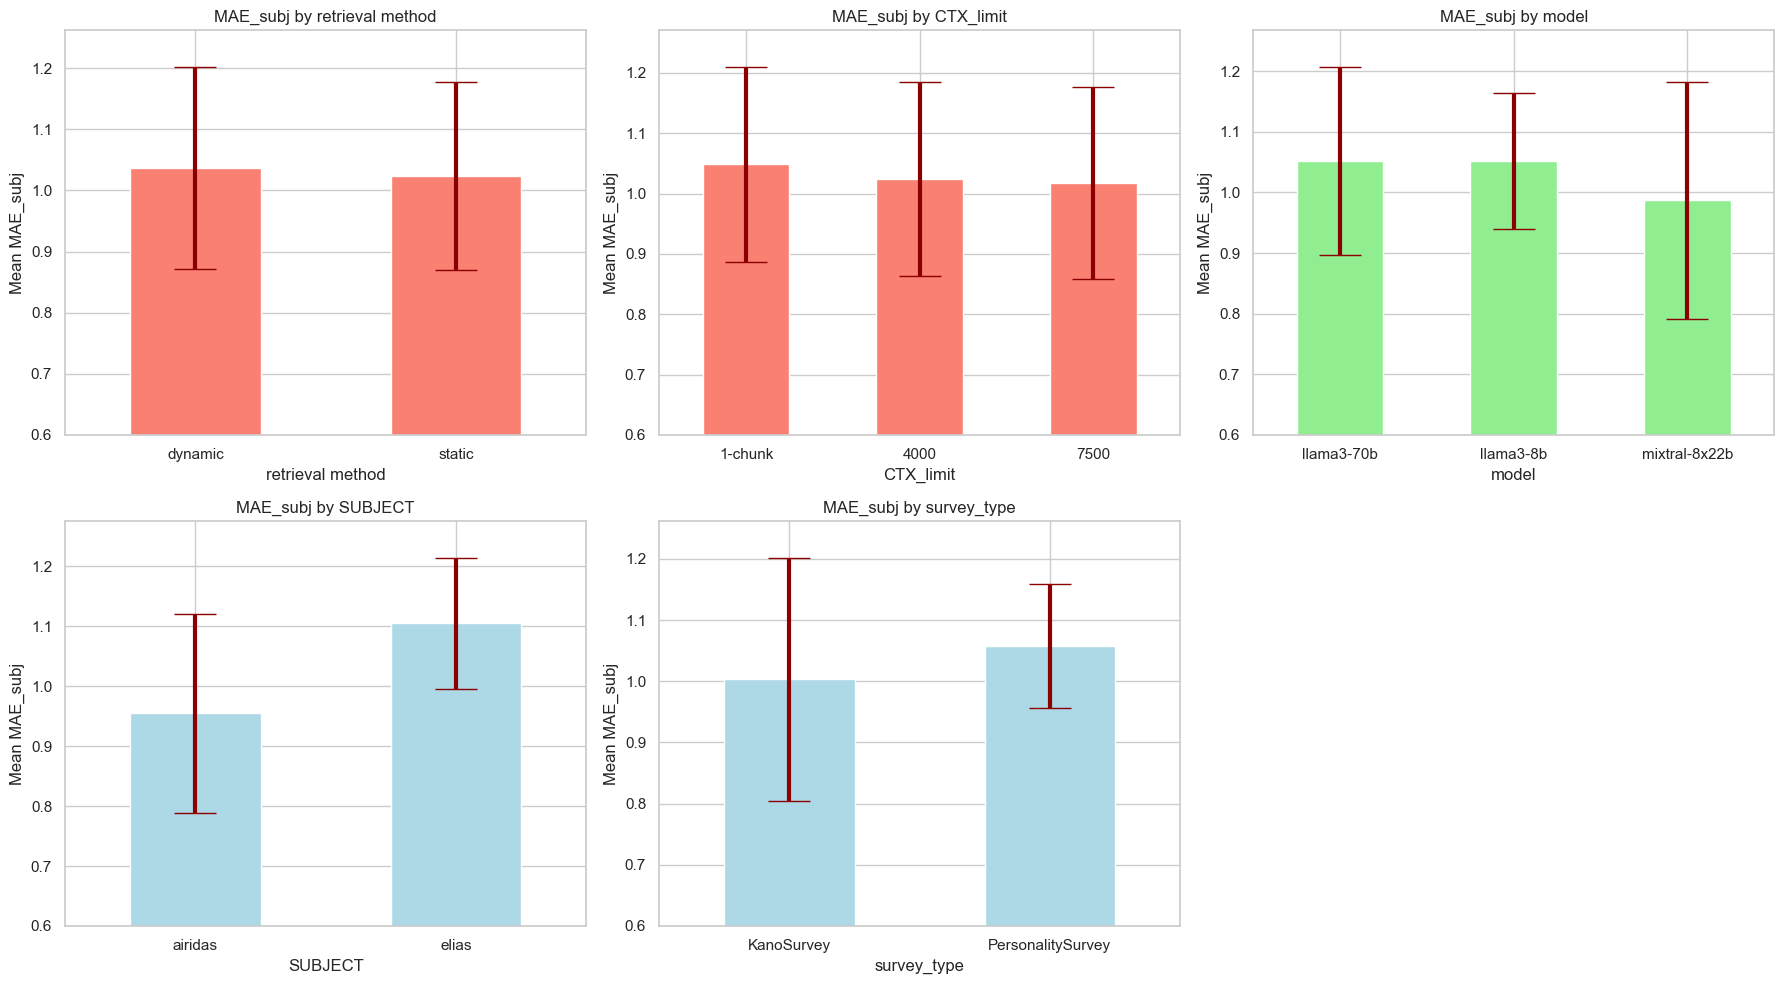

In [329]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named `df`
filtered_df = dfg[dfg['is_base'] == False]
parameters = ['retrieval method', 'CTX_limit', 'model', 'SUBJECT', 'survey_type']
plt.figure(figsize=(18, 10))
for i, param in enumerate(parameters, 1):
    plt.subplot(2, 3, i)

    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters


    # Group by the parameter and calculate mean MAE_subj
    stds = filtered_df.groupby(param)['MAE_subj'].std()
    means = filtered_df.groupby(param)['MAE_subj'].mean()
    means.plot(kind='bar', color=colors, yerr=stds, error_kw={'capsize': 15, 'ecolor': 'darkred', 'elinewidth': 3, 'alpha': 1})
    plt.title(f'MAE_subj by {param}')
    plt.ylabel('Mean MAE_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=0.6)  # Set the minimum y-axis limit

plt.tight_layout()
plt.show()

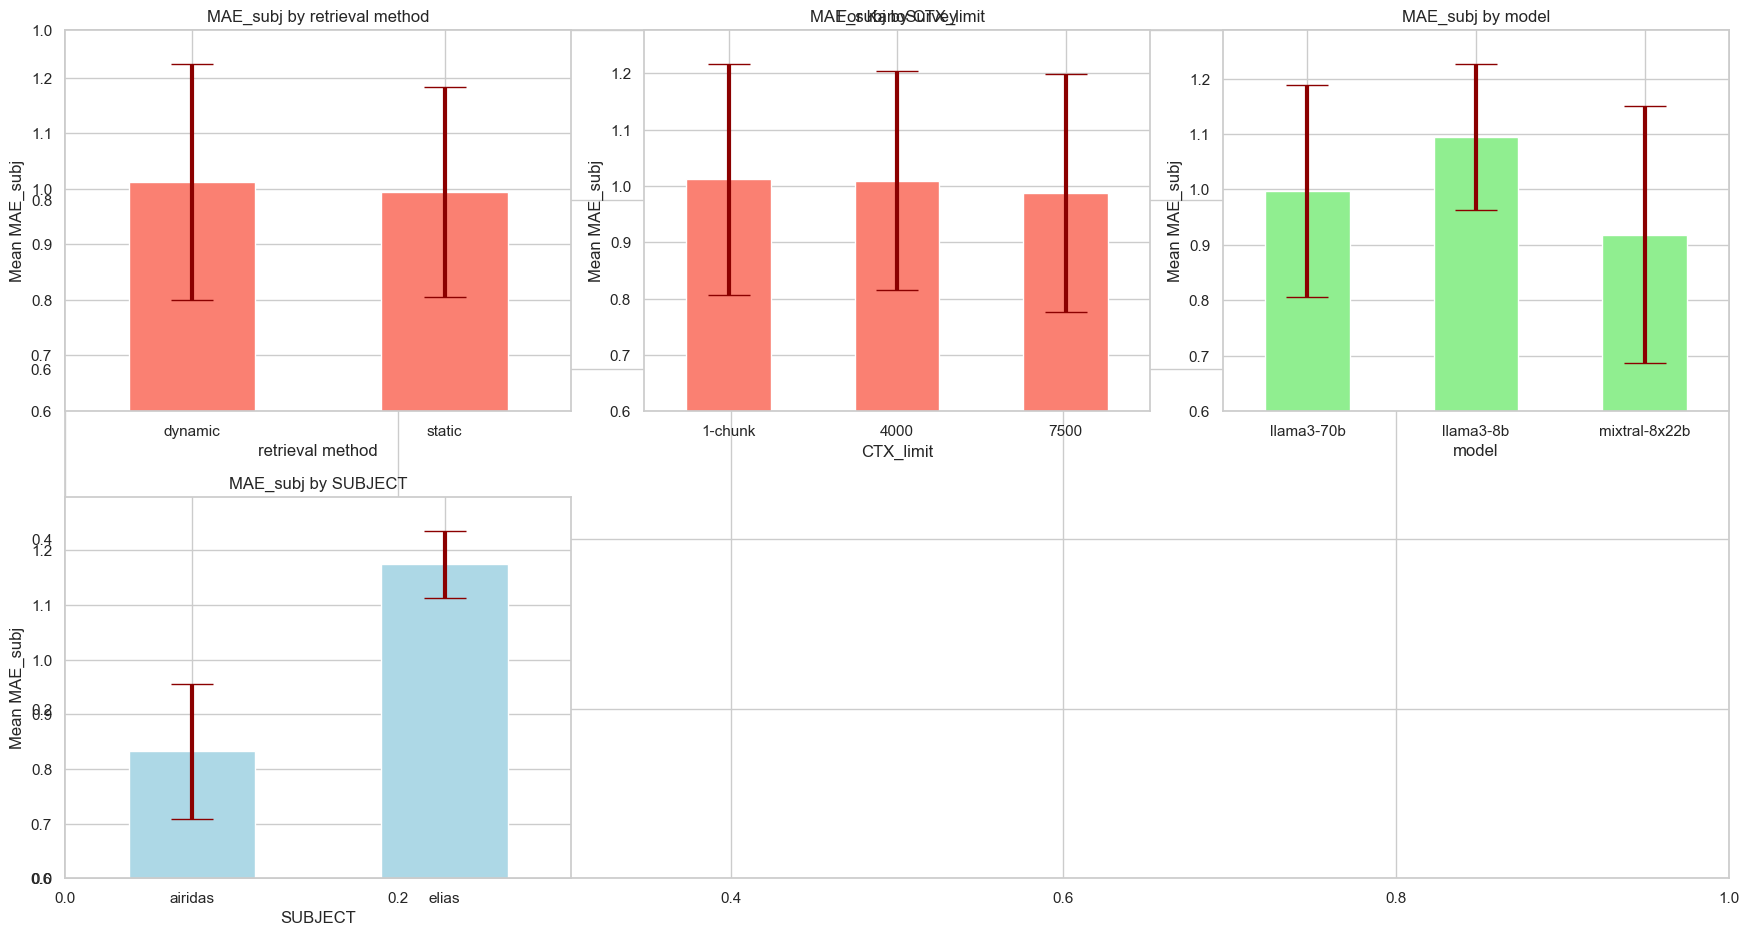

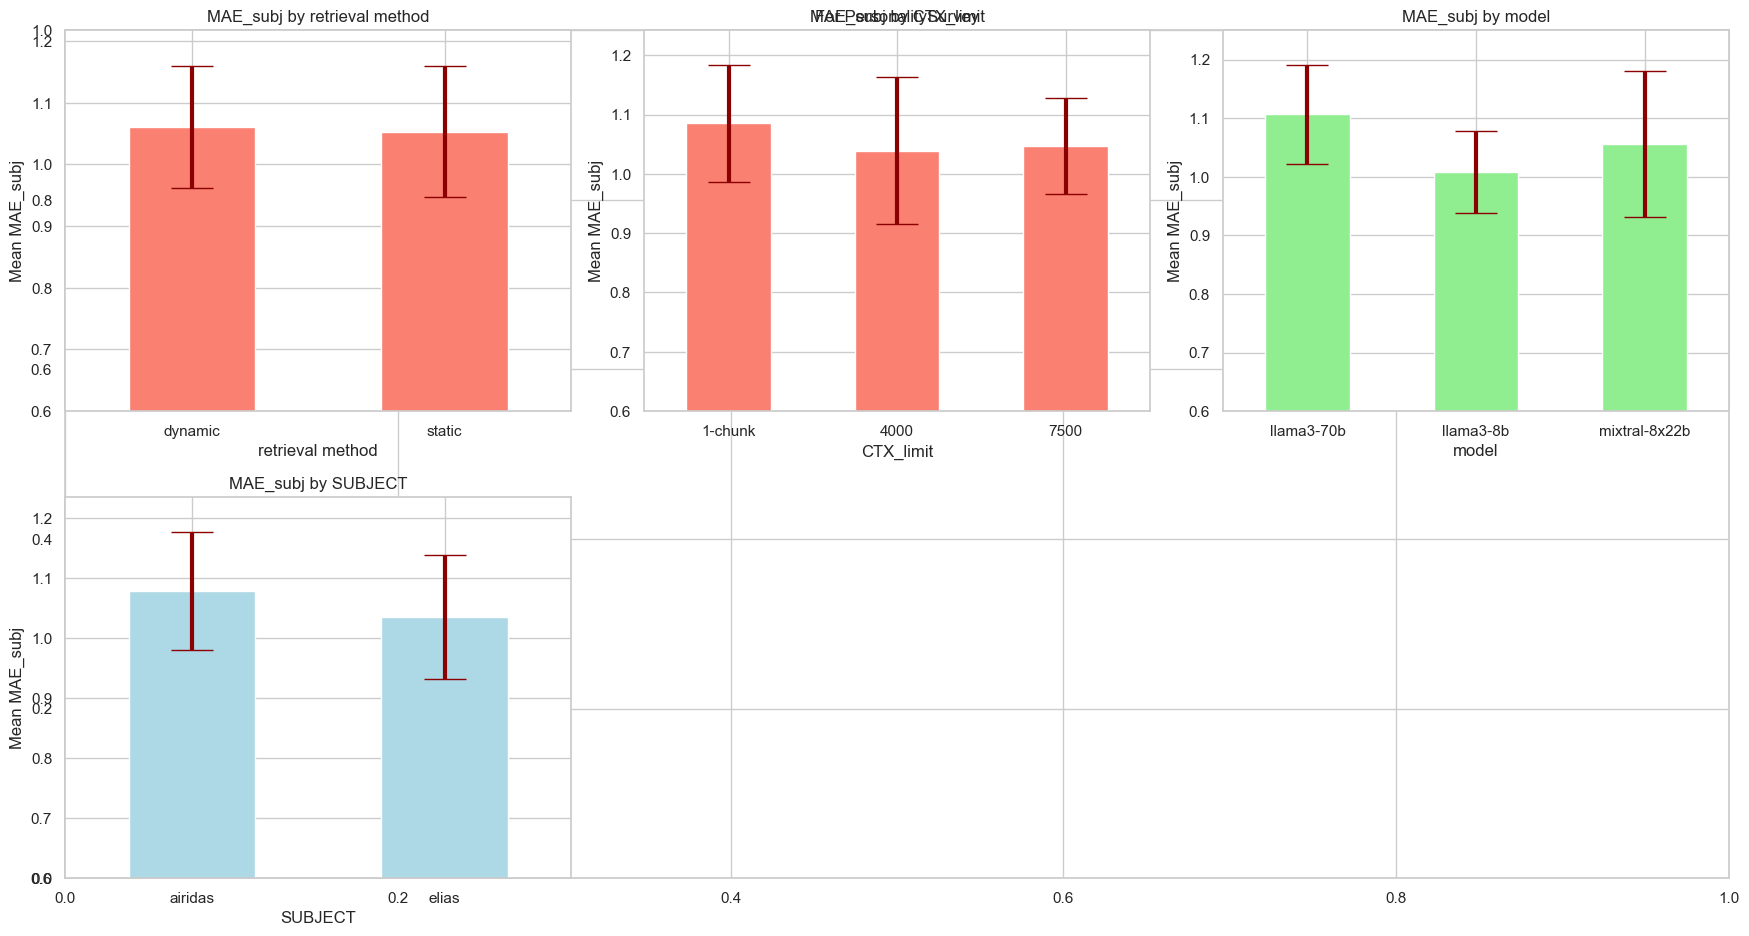

In [331]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named `df`

for srv in ['KanoSurvey', "PersonalitySurvey"]:
    filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == srv)]
    parameters = ['retrieval method', 'CTX_limit', 'model', 'SUBJECT']
    plt.figure(figsize=(18, 10))

    plt.title(f'For {srv}')
    for i, param in enumerate(parameters, 1):
        plt.subplot(2, 3, i)

        if param == 'SUBJECT':
            colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
        elif param == 'survey_type':
            colors = ['lightblue', 'lightblue']
        elif param == 'model':
            colors = ['lightgreen', 'lightgreen', 'lightgreen']
        else:
            colors = 'salmon'  # General color for other parameters


        # Group by the parameter and calculate mean MAE_subj
        stds = filtered_df.groupby(param)['MAE_subj'].std()
        means = filtered_df.groupby(param)['MAE_subj'].mean()
        means.plot(kind='bar', color=colors, yerr=stds, error_kw={'capsize': 15, 'ecolor': 'darkred', 'elinewidth': 3, 'alpha': 1})
        plt.title(f'MAE_subj by {param}')
        plt.ylabel('Mean MAE_subj')
        plt.xticks(rotation=0)
        plt.ylim(bottom=0.6)  # Set the minimum y-axis limit

    plt.tight_layout()
    plt.show()

For KanoSurvey and airidas


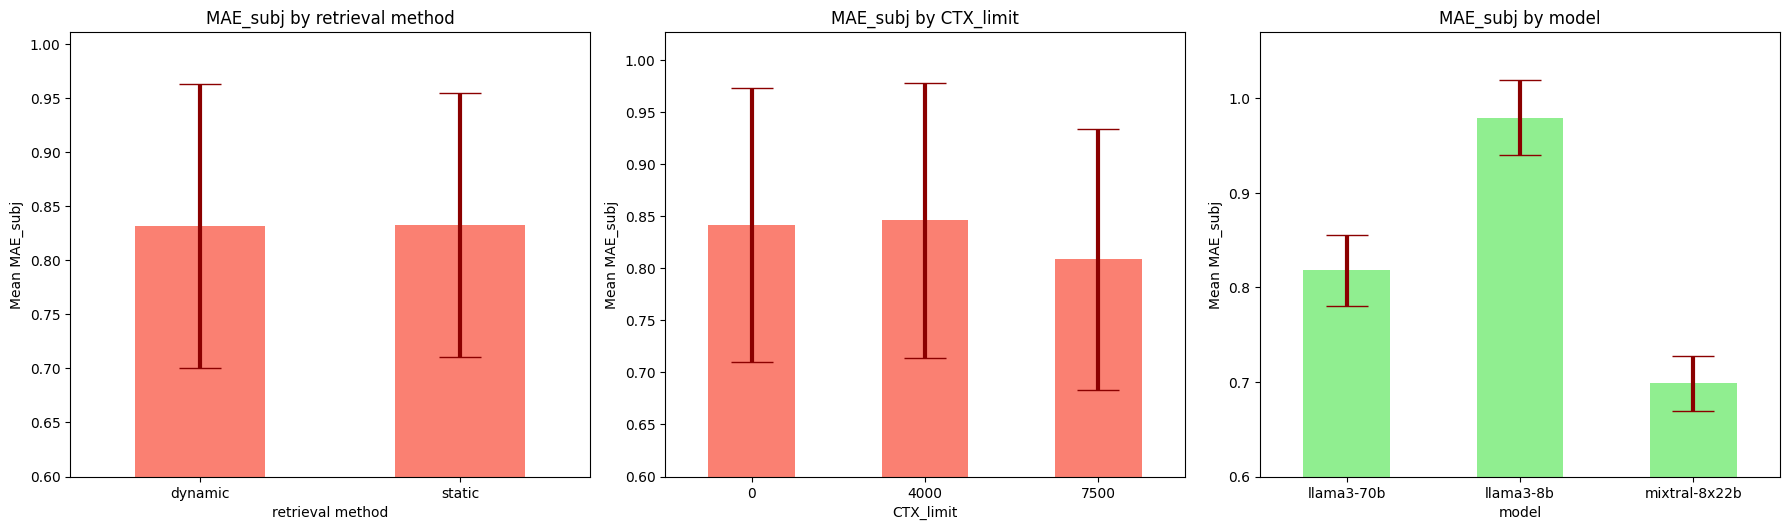

For PersonalitySurvey and airidas


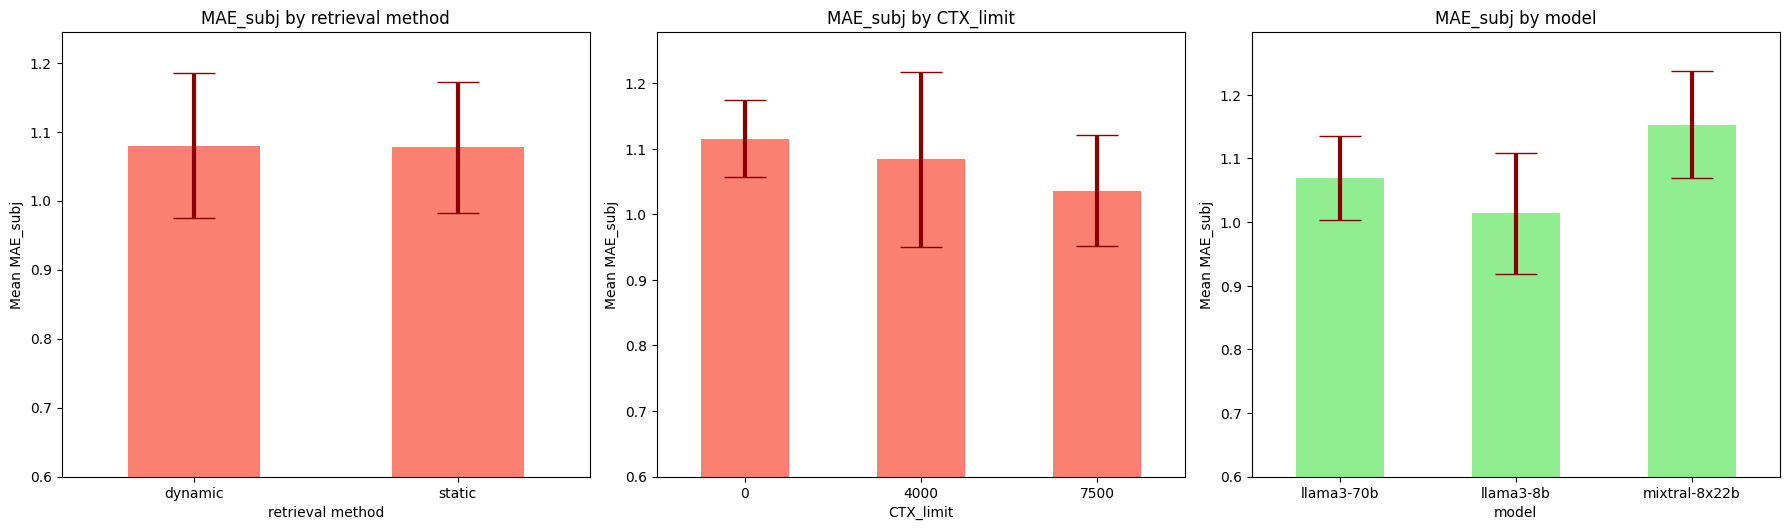

For KanoSurvey and elias


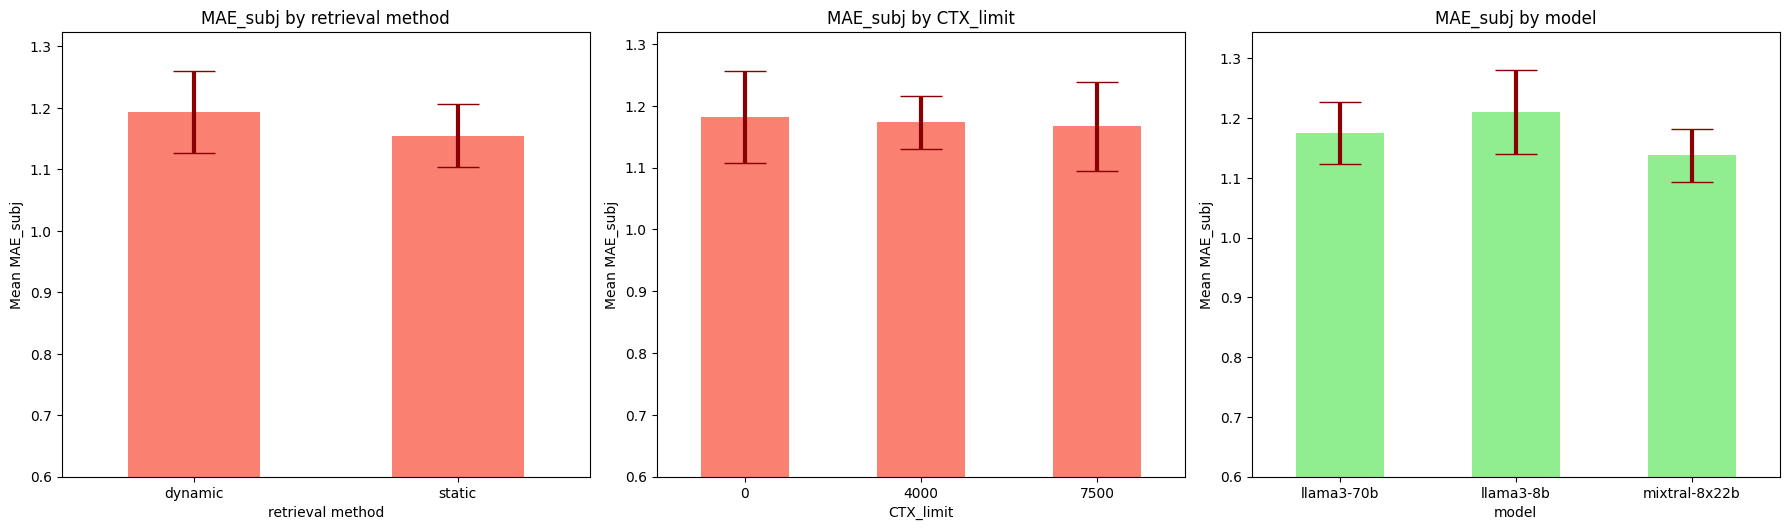

For PersonalitySurvey and elias


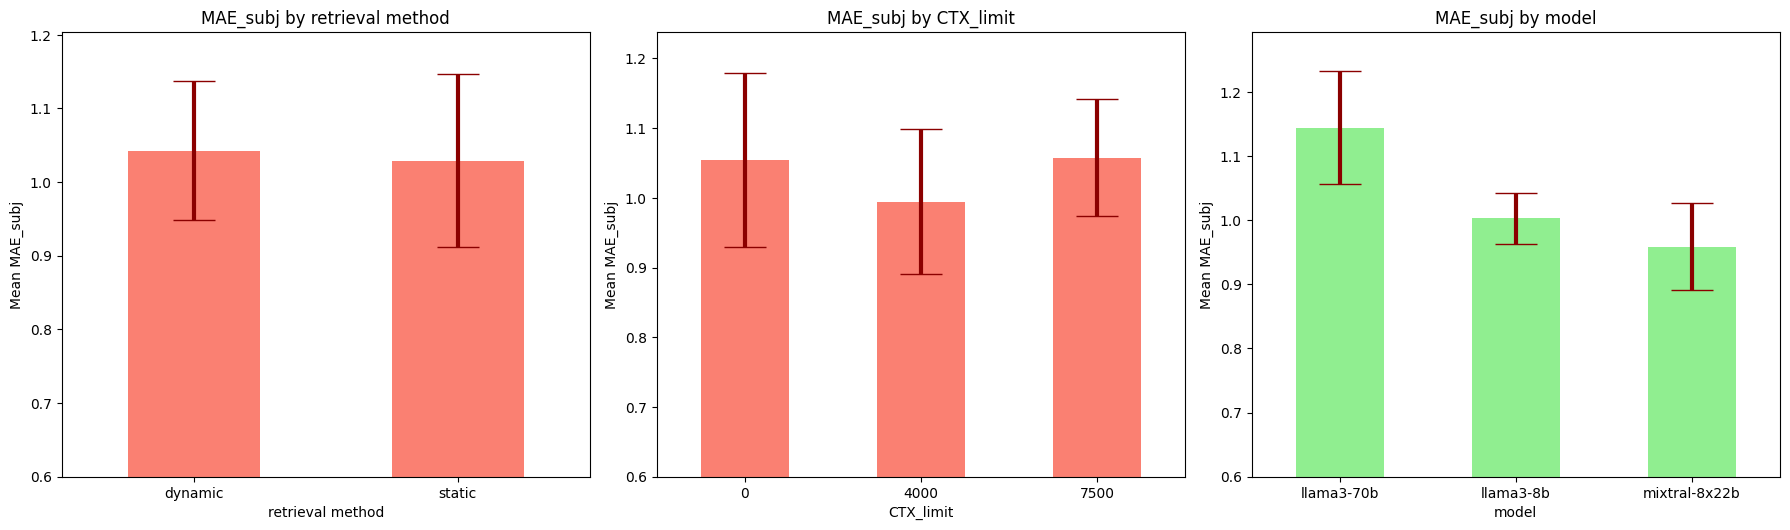

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named `df`
for subj in ['airidas', 'elias']:
    for srv in ['KanoSurvey', "PersonalitySurvey"]:
        filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == srv) & (dfg['SUBJECT'] == subj)]
        parameters = ['retrieval method', 'CTX_limit', 'model']
        plt.figure(figsize=(18, 10))

        print(f'For {srv} and {subj}')
        for i, param in enumerate(parameters, 1):
            plt.subplot(2, 3, i)

            if param == 'SUBJECT':
                colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
            elif param == 'survey_type':
                colors = ['lightblue', 'lightblue']
            elif param == 'model':
                colors = ['lightgreen', 'lightgreen', 'lightgreen']
            else:
                colors = 'salmon'  # General color for other parameters


            # Group by the parameter and calculate mean MAE_subj
            stds = filtered_df.groupby(param)['MAE_subj'].std()
            means = filtered_df.groupby(param)['MAE_subj'].mean()
            means.plot(kind='bar', color=colors, yerr=stds, error_kw={'capsize': 15, 'ecolor': 'darkred', 'elinewidth': 3, 'alpha': 1})
            plt.title(f'MAE_subj by {param}')
            plt.ylabel('Mean MAE_subj')
            plt.xticks(rotation=0)
            plt.ylim(bottom=0.6)  # Set the minimum y-axis limit

        plt.tight_layout()
        plt.show()

For KanoSurvey and airidas and mixtral-8x22b


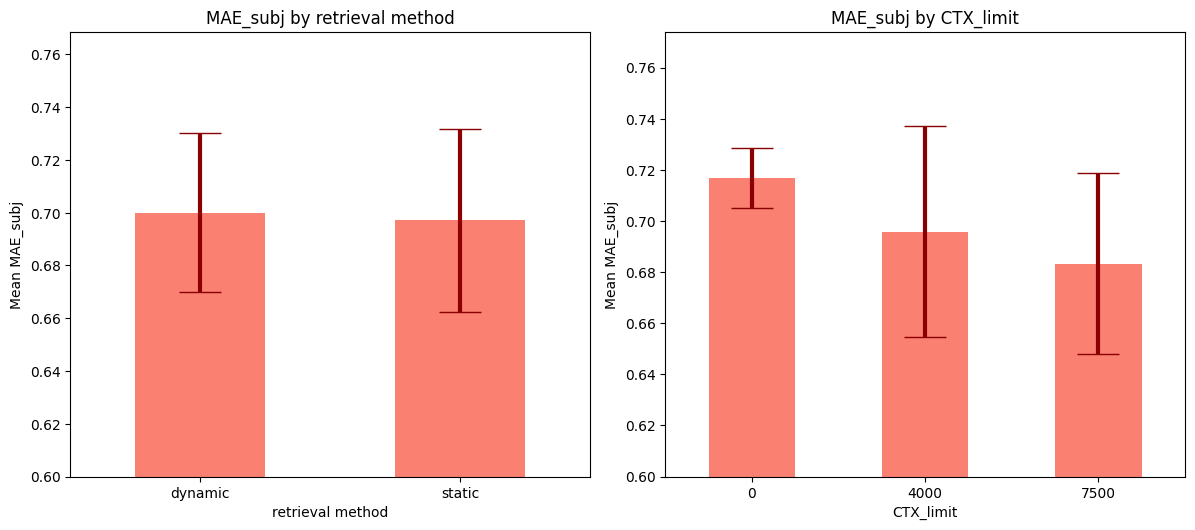

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named `df`
filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == "KanoSurvey") & (dfg['SUBJECT'] == "airidas") & (dfg['model'] == "mixtral-8x22b")]
parameters = ['retrieval method', 'CTX_limit']
plt.figure(figsize=(18, 10))

print(f'For KanoSurvey and airidas and mixtral-8x22b')
for i, param in enumerate(parameters, 1):
    plt.subplot(2, 3, i)

    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters


    # Group by the parameter and calculate mean MAE_subj
    stds = filtered_df.groupby(param)['MAE_subj'].std()
    means = filtered_df.groupby(param)['MAE_subj'].mean()
    means.plot(kind='bar', color=colors, yerr=stds, error_kw={'capsize': 15, 'ecolor': 'darkred', 'elinewidth': 3, 'alpha': 1})
    plt.title(f'MAE_subj by {param}')
    plt.ylabel('Mean MAE_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=0.6)  # Set the minimum y-axis limit

plt.tight_layout()
plt.show()

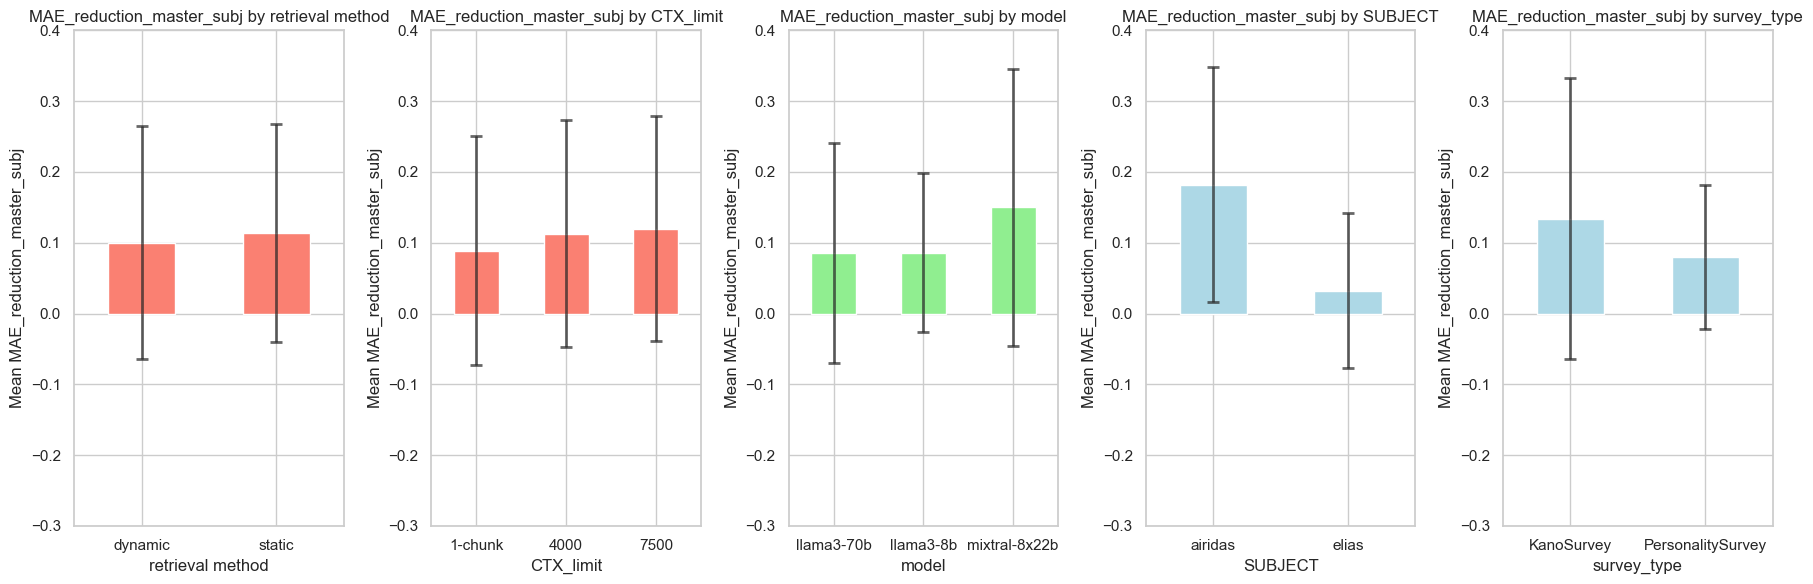

In [235]:
filtered_df = dfg[dfg['is_base'] == False]

# Define parameters of interest
parameters = ['retrieval method', 'CTX_limit', 'model',  'SUBJECT', 'survey_type',]

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_master_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_master_subj by {param}')
    plt.ylabel('Mean MAE_reduction_master_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.3, top=0.4) # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

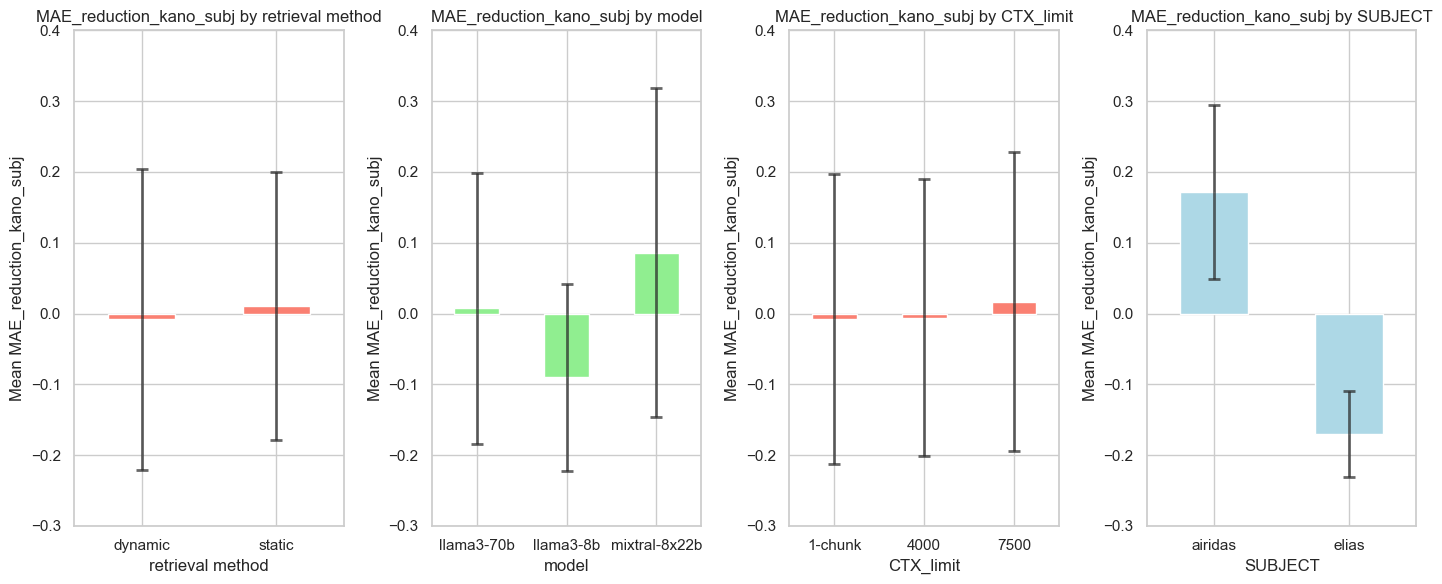

In [258]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_survey"]["KanoSurvey"], base_name="kano").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == 'KanoSurvey')]

# Define parameters of interest
parameters = ['retrieval method', 'model', 'CTX_limit','SUBJECT',]

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_kano_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_kano_subj by {param}')
    plt.ylabel('Mean MAE_reduction_kano_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.3, top=0.4)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

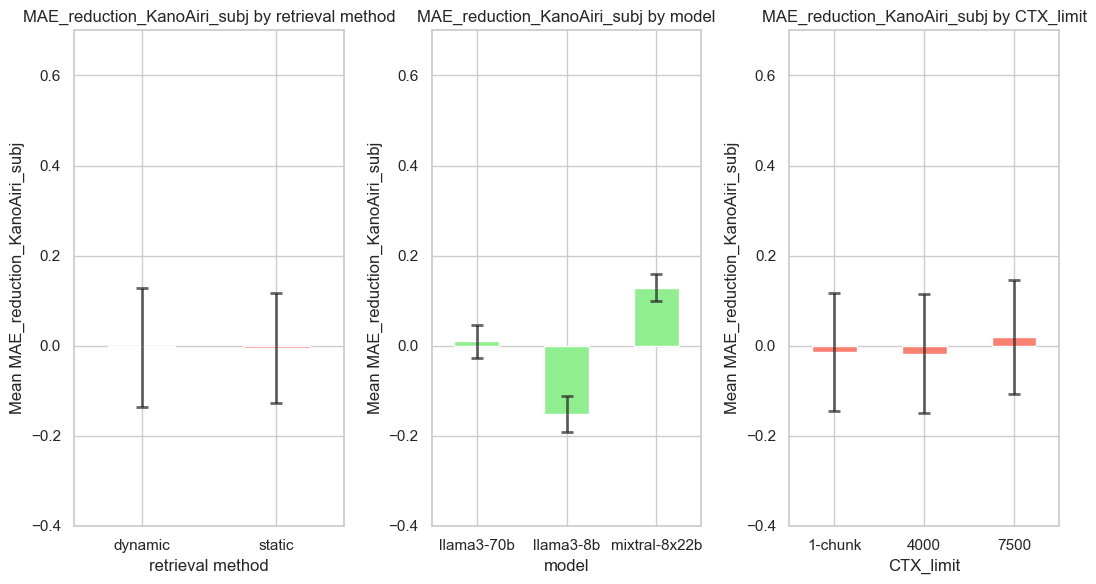

In [279]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_survey_subject"]["KanoAiri"], base_name="KanoAiri").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == 'KanoSurvey') & (dfg['SUBJECT'] == 'airidas')]

# Define parameters of interest
parameters = ['retrieval method', 'model', 'CTX_limit']

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_KanoAiri_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_KanoAiri_subj by {param}')
    plt.ylabel('Mean MAE_reduction_KanoAiri_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.4, top=0.7)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

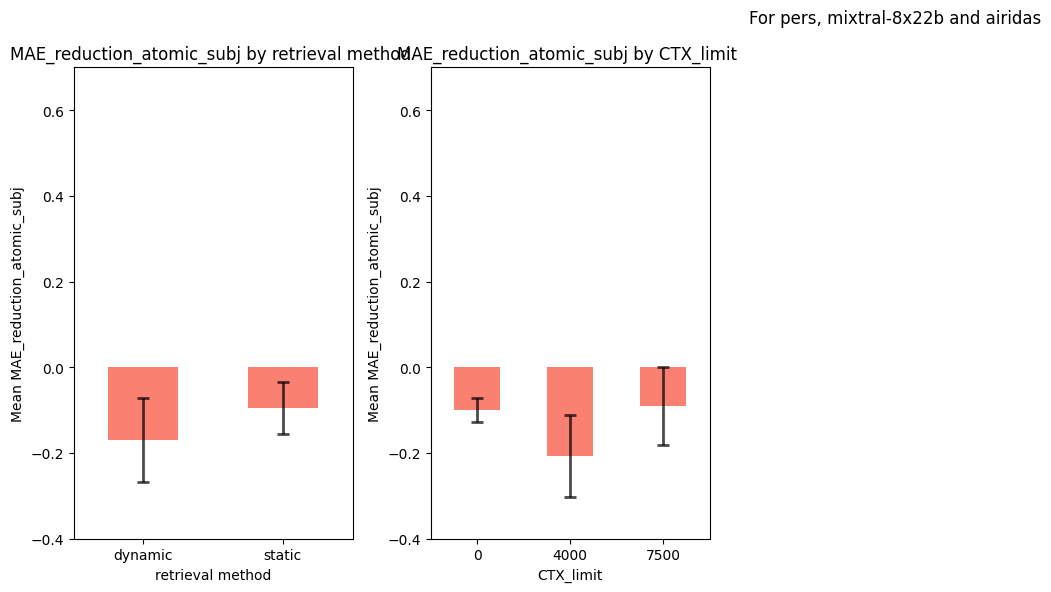

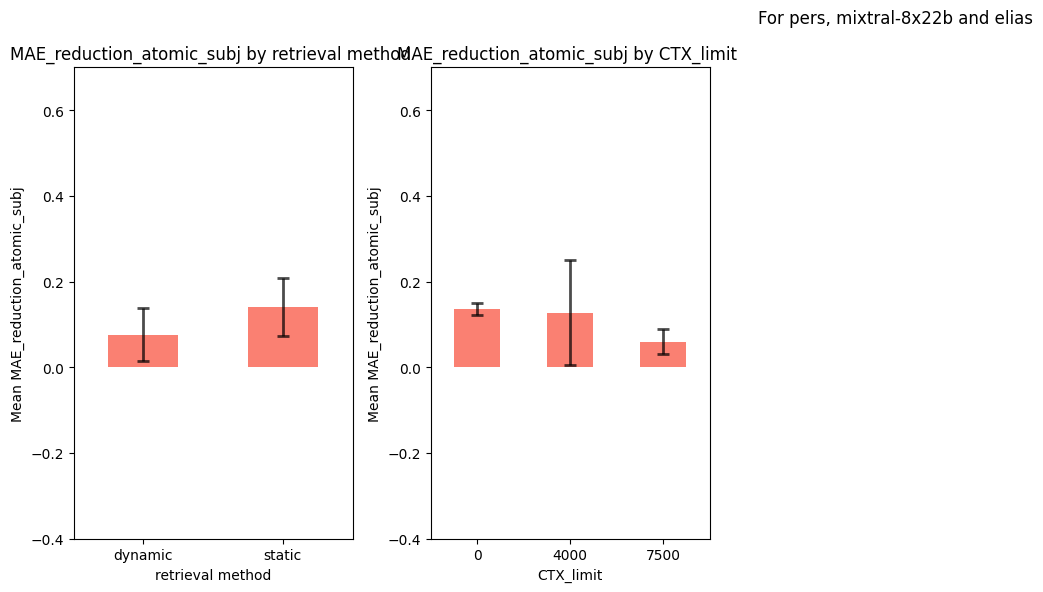

In [24]:
# for index, sim_row in dfg.iterrows():
#     for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["atomic"]["base-kano-29_mixtral-8x22b_V7_airi"], base_name="").items():
#         dfg.at[index, key] = value


for subj in ['airidas', 'elias']:
    filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == 'PersonalitySurvey') & (dfg['SUBJECT'] == subj) & (dfg['model'] == 'mixtral-8x22b')]

    # Define parameters of interest
    parameters = ['retrieval method','CTX_limit']

    # Create a figure to hold the plots
    plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

    # Loop through each parameter and create a bar chart
    for i, param in enumerate(parameters, 1):
        plt.subplot(1, 5, i)  # Horizontal layout of plots
        # Group by the parameter
        group = filtered_df.groupby(param)['MAE_reduction_subj']
        means = group.mean()
        errors = group.std()  # Calculate standard deviation for error bars

        # Assign specific colors for "SUBJECT" and "survey_type"
        if param == 'SUBJECT':
            colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
        elif param == 'survey_type':
            colors = ['lightblue', 'lightblue']
        elif param == 'model':
            colors = ['lightgreen', 'lightgreen', 'lightgreen']
        else:
            colors = 'salmon'  # General color for other parameters

        means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
        plt.title(f'MAE_reduction_atomic_subj by {param} ')
        plt.suptitle(f'For pers, mixtral-8x22b and {subj}') 
        plt.ylabel('Mean MAE_reduction_atomic_subj')
        plt.xticks(rotation=0)
        plt.ylim(bottom=-0.4, top=0.7)  # Expecting negative values so setting lower y limit to -1

    plt.tight_layout()
    plt.show()

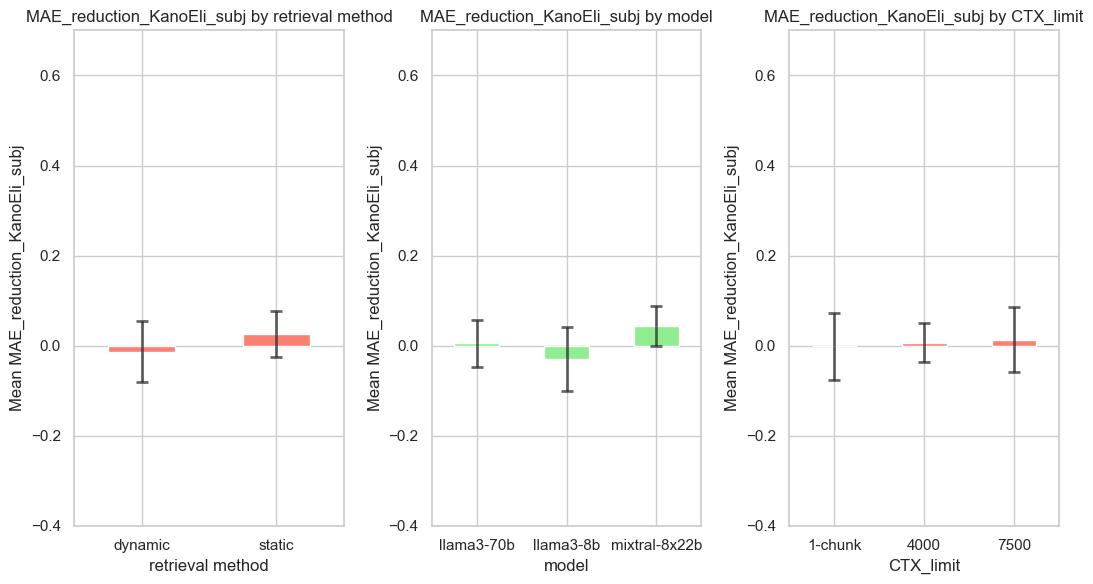

In [280]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_survey_subject"]["KanoEli"], base_name="KanoEli").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == 'KanoSurvey') & (dfg['SUBJECT'] == 'elias')]

# Define parameters of interest
parameters = ['retrieval method', 'model', 'CTX_limit']

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_KanoEli_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_KanoEli_subj by {param}')
    plt.ylabel('Mean MAE_reduction_KanoEli_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.4, top=0.7)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

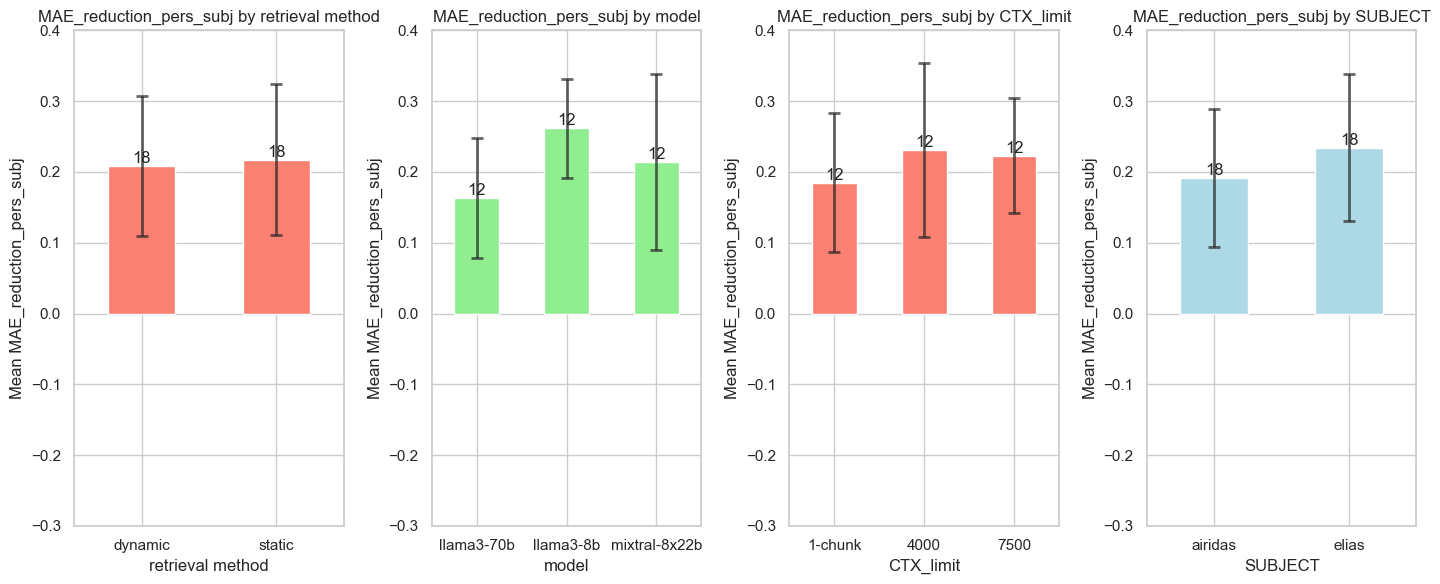

In [271]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_survey"]["PersonalitySurvey"], base_name="pers").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == 'PersonalitySurvey')]

# Define parameters of interest
parameters = ['retrieval method', 'model', 'CTX_limit','SUBJECT',]

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_pers_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars
    counts = group.size()

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    bars = means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})

    # Add counts above bars
    for bar, count in zip(bars.patches, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', ha='center', va='bottom')
        
    plt.title(f'MAE_reduction_pers_subj by {param}')
    plt.ylabel('Mean MAE_reduction_pers_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.3, top=0.4)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

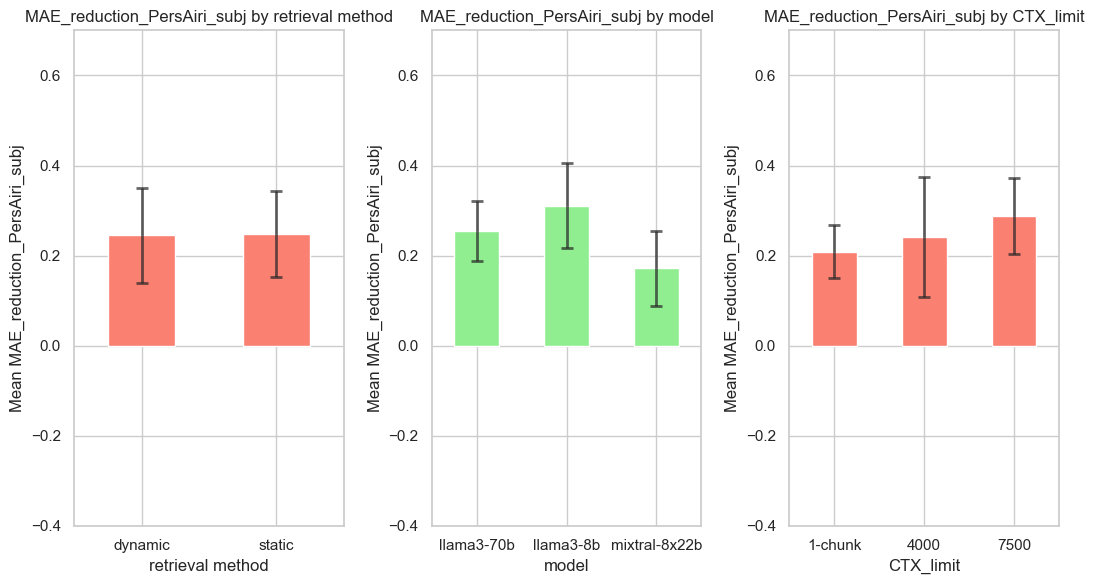

In [276]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_survey_subject"]["PersAiri"], base_name="PersAiri").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == 'PersonalitySurvey') & (dfg['SUBJECT'] == 'airidas')]

# Define parameters of interest
parameters = ['retrieval method', 'model', 'CTX_limit']

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_PersAiri_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_PersAiri_subj by {param}')
    plt.ylabel('Mean MAE_reduction_PersAiri_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.4, top=0.7)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

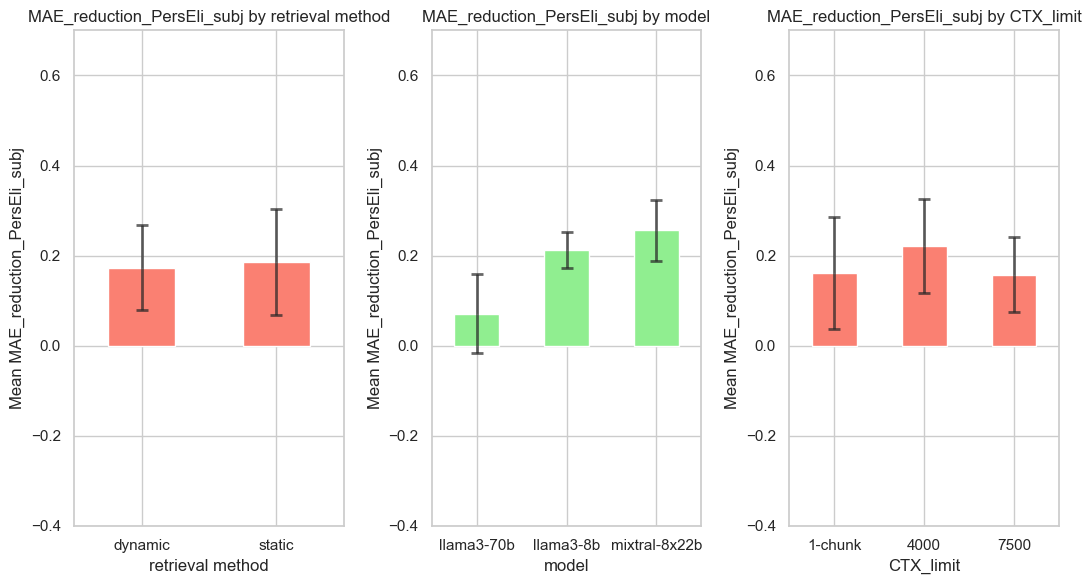

In [277]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_survey_subject"]["PersEli"], base_name="PersEli").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == 'PersonalitySurvey') & (dfg['SUBJECT'] == 'elias')]

# Define parameters of interest
parameters = ['retrieval method', 'model', 'CTX_limit']

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_PersEli_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_PersEli_subj by {param}')
    plt.ylabel('Mean MAE_reduction_PersEli_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.4, top=0.7)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

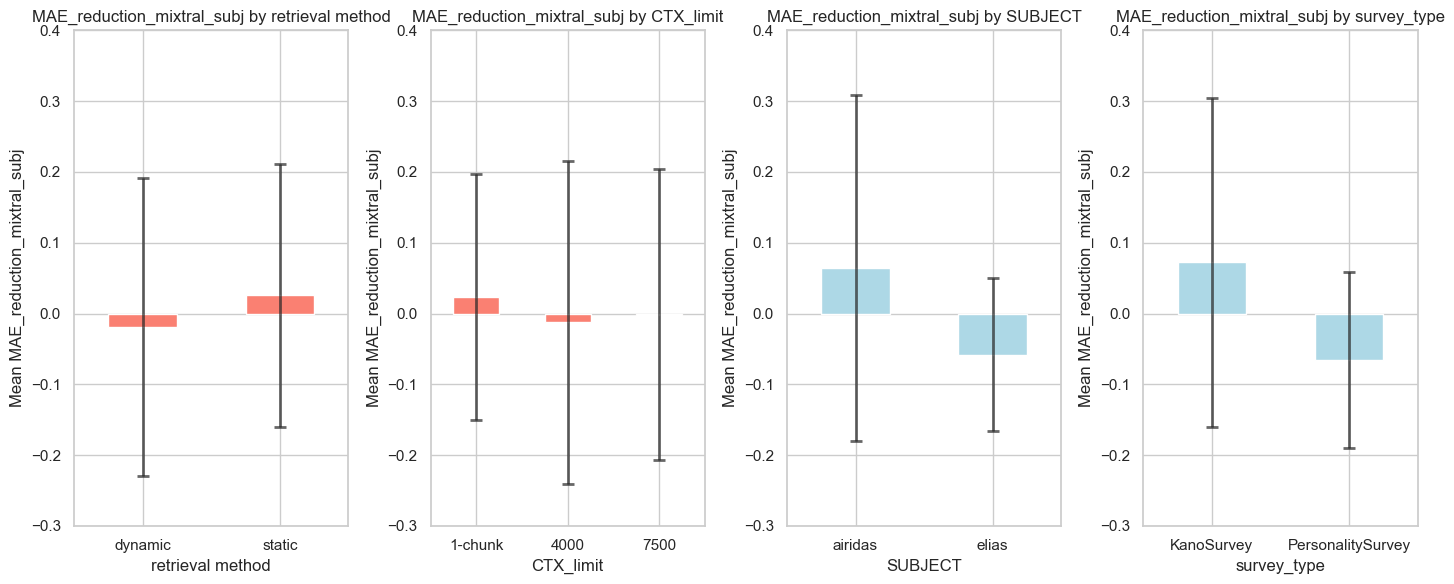

In [259]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_model"]["mixtral-8x22b"], base_name="mixtral").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['model'] == 'mixtral-8x22b')]

# Define parameters of interest
parameters = ['retrieval method', 'CTX_limit','SUBJECT', 'survey_type',]

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_mixtral_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_mixtral_subj by {param}')
    plt.ylabel('Mean MAE_reduction_mixtral_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.3, top=0.4)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

In [ ]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_model"]["mixtral-8x22b"], base_name="mixtral").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['model'] == 'mixtral-8x22b')]

# Define parameters of interest
parameters = ['retrieval method', 'CTX_limit','SUBJECT', 'survey_type',]

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_mixtral_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_master_subj by {param}')
    plt.ylabel('Mean MAE_reduction_master_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.3, top=0.4)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

#### Old Viz

C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_13932\2354292823.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, y=ylabel, x='MAE_airi_mean' if 'Airidas' in title else 'MAE_eli_mean', ax=ax, palette=colors, orient='h')
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_13932\2354292823.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, y=ylabel, x='MAE_airi_mean' if 'Airidas' in title else 'MAE_eli_mean', ax=ax, palette=colors, orient='h')
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_13932\2354292823.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=Fa

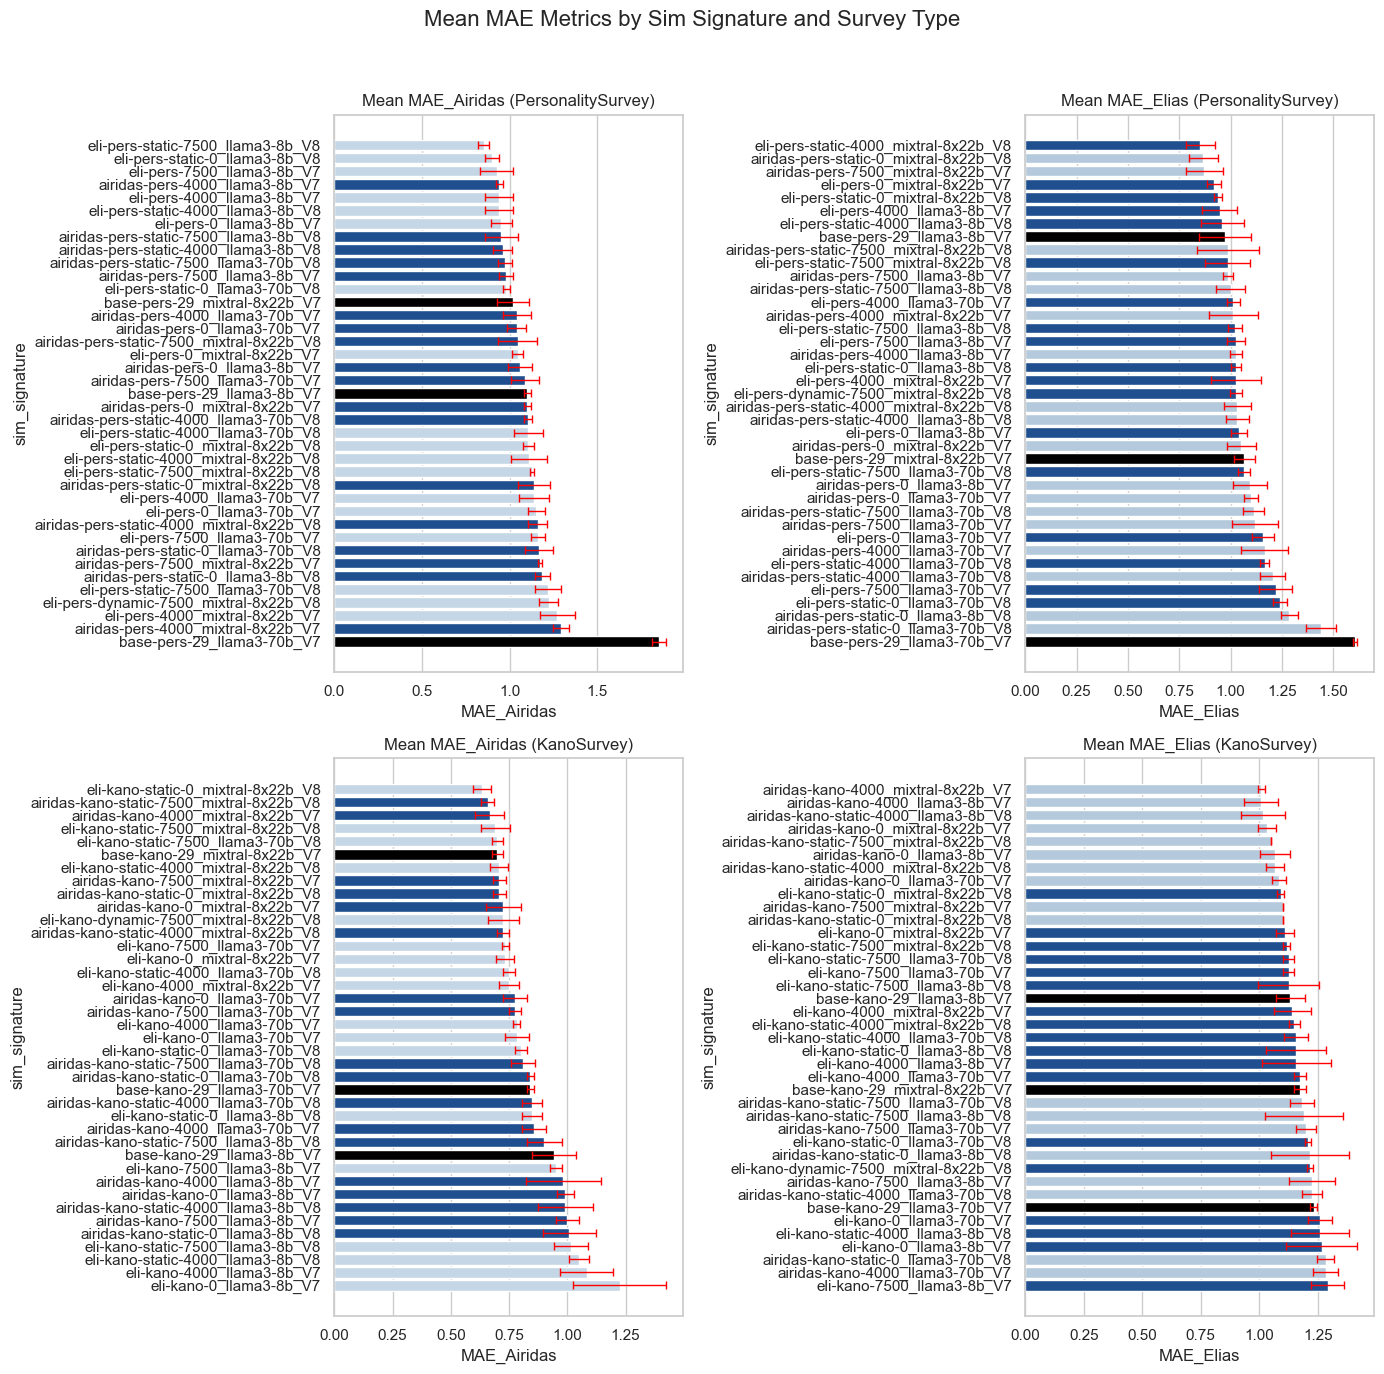

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style
sns.set(style="whitegrid")

# Sorting and filtering the dataframe for each plot
sorted_airidas_personality = dfg[(dfg['survey_type'] == 'PersonalitySurvey')].sort_values('MAE_airi_mean', ascending=True)
sorted_airidas_kano = dfg[(dfg['survey_type'] == 'KanoSurvey')].sort_values('MAE_airi_mean', ascending=True)
sorted_elias_personality = dfg[(dfg['survey_type'] == 'PersonalitySurvey')].sort_values('MAE_eli_mean', ascending=True)
sorted_elias_kano = dfg[(dfg['survey_type'] == 'KanoSurvey')].sort_values('MAE_eli_mean', ascending=True)

# Custom color functions
def get_colors_airidas(df):
    colors = []
    for _, row in df.iterrows():
        if row['SUBJECT'] != 'airidas' and not row['is_base']:
            colors.append('#bfd7ec')
        elif row['is_base']:
            colors.append('black')
        else:
            colors.append('#0c4da2')
    return colors

def get_colors_elias(df):
    colors = []
    for _, row in df.iterrows():
        if row['SUBJECT'] != 'elias' and not row['is_base']:
            colors.append('#adcbe3')
        elif row['is_base']:
            colors.append('black')
        else:
            colors.append('#0c4da2')
    return colors

colors_airidas_p = get_colors_airidas(sorted_airidas_personality)
colors_airidas_k = get_colors_airidas(sorted_airidas_kano)
colors_elias_p = get_colors_elias(sorted_elias_personality)
colors_elias_k = get_colors_elias(sorted_elias_kano)

fig, axs = plt.subplots(2, 2, figsize=(14, 14))
fig.suptitle('Mean MAE Metrics by Sim Signature and Survey Type', fontsize=16)

# Adding horizontal bars and error bars
for (data, ax, colors, ylabel, title) in [
    (sorted_airidas_personality, axs[0, 0], colors_airidas_p, 'sim_signature', 'Mean MAE_Airidas (PersonalitySurvey)'),
    (sorted_airidas_kano, axs[1, 0], colors_airidas_k, 'sim_signature', 'Mean MAE_Airidas (KanoSurvey)'),
    (sorted_elias_personality, axs[0, 1], colors_elias_p, 'sim_signature', 'Mean MAE_Elias (PersonalitySurvey)'),
    (sorted_elias_kano, axs[1, 1], colors_elias_k, 'sim_signature', 'Mean MAE_Elias (KanoSurvey)')
]:
    sns.barplot(data=data, y=ylabel, x='MAE_airi_mean' if 'Airidas' in title else 'MAE_eli_mean', ax=ax, palette=colors, orient='h')
    if 'Airidas' in title:
        ax.errorbar(data['MAE_airi_mean'], data[ylabel], xerr=data['MAE_airi_std'], fmt='none', ecolor='red', capsize=3, elinewidth=1, alpha=1 )
    else:
        ax.errorbar(data['MAE_eli_mean'], data[ylabel], xerr=data['MAE_eli_std'], fmt='none', ecolor='red', capsize=3, elinewidth=1, alpha=1)
    ax.set_title(title)
    ax.set_xlabel(title.split(' ')[1])
    ax.set_ylabel(ylabel)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

###########################
# Average the crossed results
###########################

In [67]:
# expoert dfg to csv
dfg.to_csv("analysis/spreadsheets/dfg-1.csv", index=False)

In [40]:
len(dfg)

61

### Hyperparameter tuning analysis (NEW)

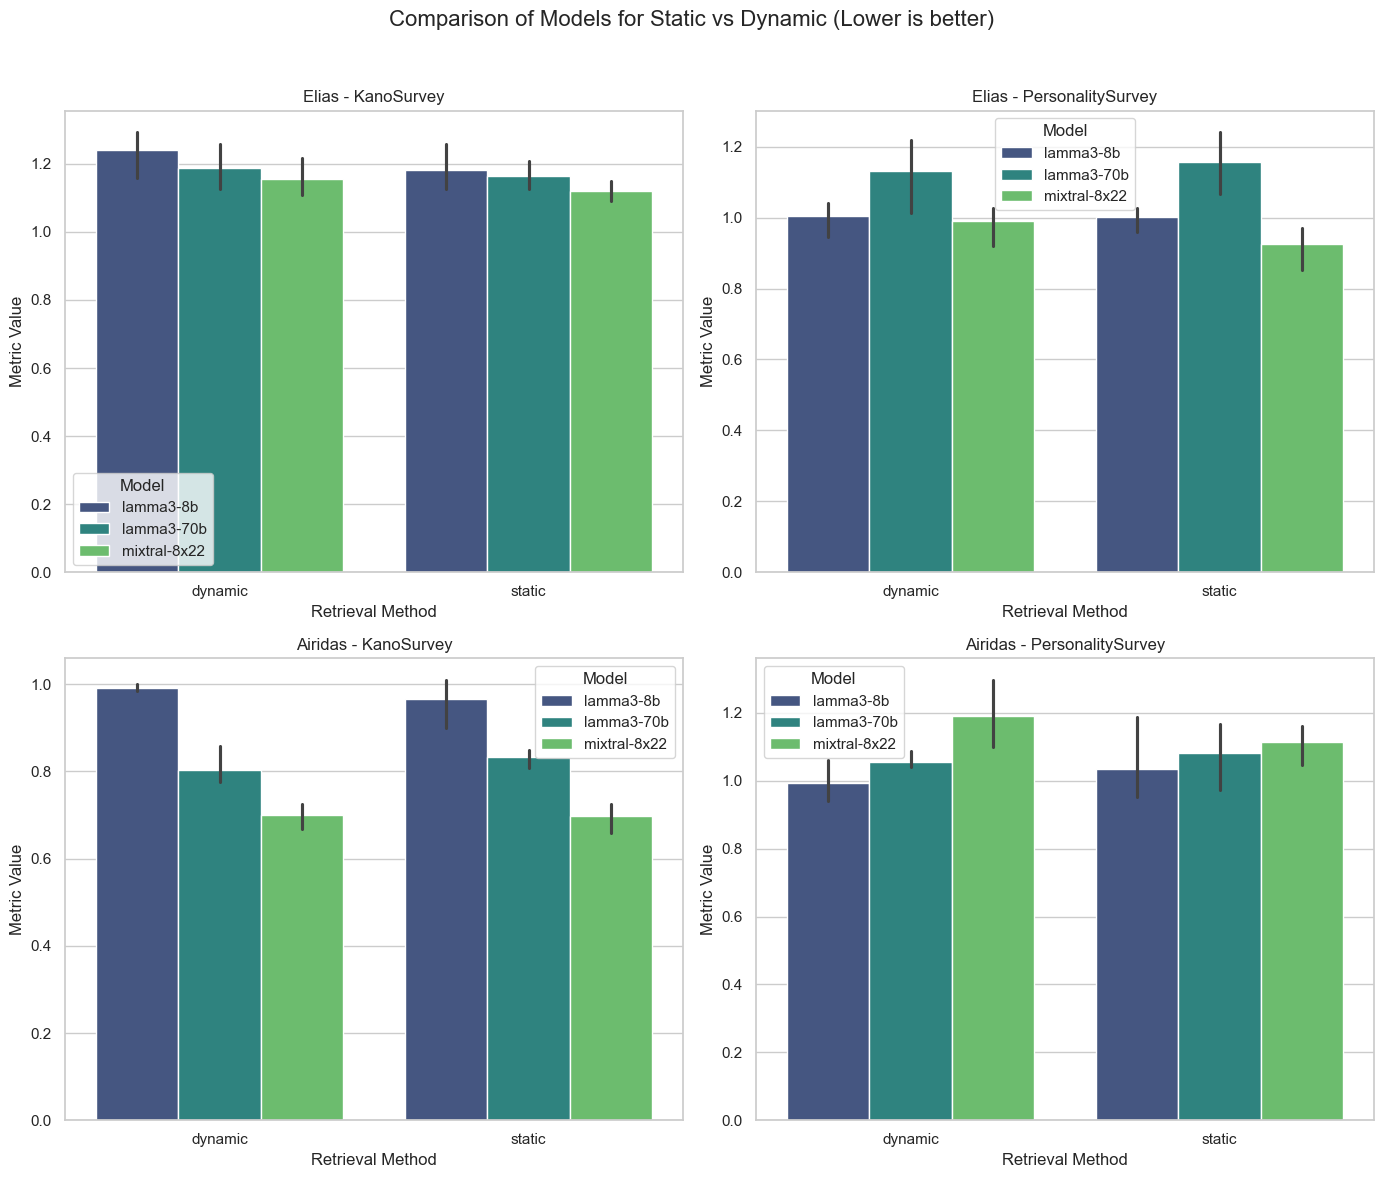

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'dfg' is your DataFrame
# Filter out rows where 'is_base' is True
df_filtered = dfg[dfg['is_base'] == False]

# Create a figure for the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns
fig.suptitle('Comparison of Models for Static vs Dynamic (Lower is better)', fontsize=16)

# Each subplot for different combinations
for i, (subject, survey_type) in enumerate([
        ('elias', 'KanoSurvey'), ('elias', 'PersonalitySurvey'),
        ('airidas', 'KanoSurvey'), ('airidas', 'PersonalitySurvey')]):

    ax = axs[i//2, i%2]
    
    # Filter data for the specific group
    df_group = df_filtered[(df_filtered['SUBJECT'] == subject) & (df_filtered['survey_type'] == survey_type)]
    
    # Separate further by model
    df_group_8b = df_group[df_group['model'] == 'llama3-8b']
    df_group_70b = df_group[df_group['model'] == 'llama3-70b']
    df_group_8x22b = df_group[df_group['model'] == 'mixtral-8x22b']
    
    # Combine the data for a comparison by retrieval method and model
    df_group_8b = df_group_8b.assign(Model='lamma3-8b')
    df_group_70b = df_group_70b.assign(Model='lamma3-70b')
    df_group_8x22b = df_group_8x22b.assign(Model='mixtral-8x22')
    df_plot = pd.concat([df_group_8b, df_group_70b, df_group_8x22b])

    # Select the correct metric based on the subject
    if subject == 'elias':
        metric_column = f'MAE_eli_mean'
    if subject == 'airidas':
        metric_column = f'MAE_airi_mean'
    df_plot['Metric Value'] = df_plot[metric_column]
    
    # Create a bar chart
    sns.barplot(data=df_plot, x='retrieval method', y='Metric Value', hue='Model', ax=ax, palette='viridis')
    
    # Setting the title and labels
    ax.set_title(f'{subject.capitalize()} - {survey_type}')
    ax.set_xlabel('Retrieval Method')
    ax.set_ylabel('Metric Value')

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()


##########################
# Add base
#########################

C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_9212\3737665853.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['Metric Value'] = df_group[metric_column]
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_9212\3737665853.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['Metric Value'] = df_group[metric_column]
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_9212\3737665853.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

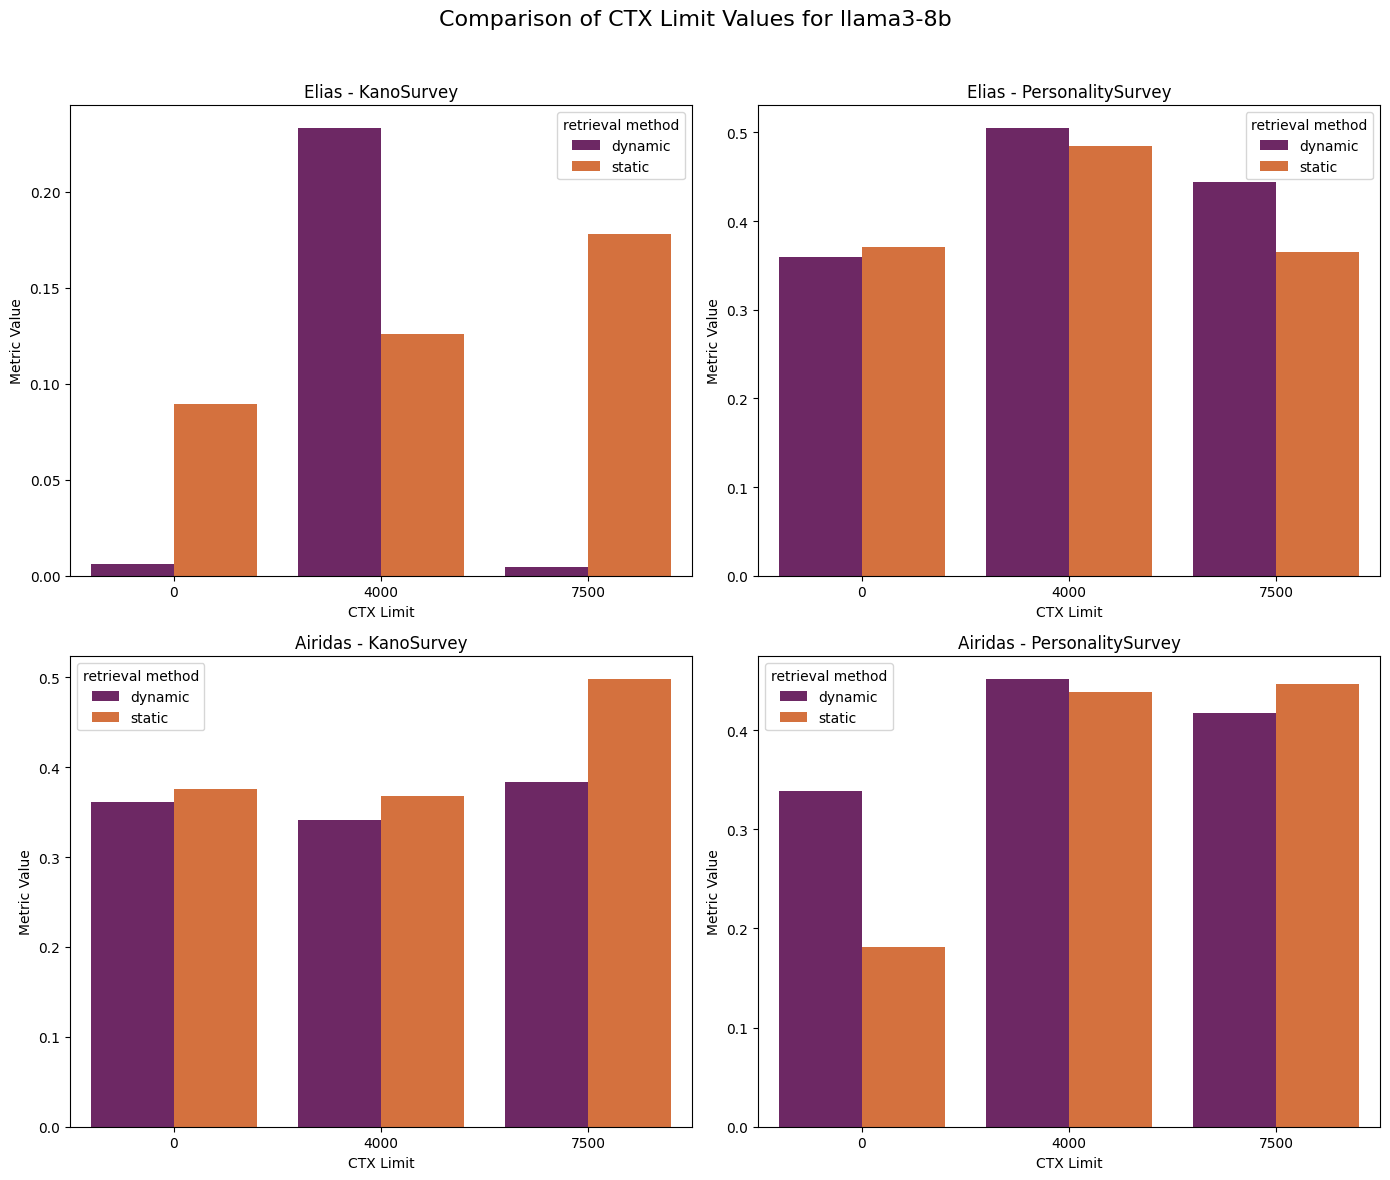

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'dfg' is your DataFrame
# Filter out rows where 'is_base' is True and 'lamma3-70b'

df_filtered = dfg[(dfg['is_base'] == False) & (dfg['model'] == 'llama3-8b')]

# Create a figure for the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns
fig.suptitle('Comparison of CTX Limit Values for llama3-8b', fontsize=16)

# Each subplot for different combinations
for i, (subject, survey_type) in enumerate([
        ('elias', 'KanoSurvey'), ('elias', 'PersonalitySurvey'),
        ('airidas', 'KanoSurvey'), ('airidas', 'PersonalitySurvey')]):

    ax = axs[i//2, i%2]
    
    # Filter data for the specific group
    df_group = df_filtered[(df_filtered['SUBJECT'] == subject) & (df_filtered['survey_type'] == survey_type)]
    
    # Select the correct metric based on the subject
    metric_column = f'p-corr_{subject.capitalize()}_mean'
    df_group['Metric Value'] = df_group[metric_column]
    
    # Create a bar chart
    sns.barplot(data=df_group, x='CTX_limit', y='Metric Value', hue='retrieval method', ax=ax, palette= "inferno")
    
    # Setting the title and labels
    ax.set_title(f'{subject.capitalize()} - {survey_type}')
    ax.set_xlabel('CTX Limit')
    ax.set_ylabel('Metric Value')

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()

### Hyperparameter tuning analysis

In [16]:
import pandas as pd
# Drop rows where SUBJECT == "airidas"
# dfg = dfg[dfg['SUBJECT'] != "airidas"]
# Compute summary statistics for each retrieval method
summary_stats = dfg.groupby('retrieval method')[['p-corr_Elias_mean', 'mean_residual_Elias_std']].agg(['mean', 'var', 'std'])
# Reset the multi-index to make the column labels more readable
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
summary_stats = summary_stats.reset_index()
# Store the summary statistics in a DataFrame
pd.DataFrame(summary_stats)

,retrieval method,p-corr_Elias_mean_mean,p-corr_Elias_mean_var,p-corr_Elias_mean_std,mean_residual_Elias_std_mean,mean_residual_Elias_std_var,mean_residual_Elias_std_std
0,base,0.306750,0.011282,0.106217,0.053978,0.002926,0.054095
1,dynamic,0.312194,0.028308,0.168249,0.065168,0.001424,0.037734
2,static,0.289597,0.019954,0.141257,0.068373,0.002071,0.045509


In [ ]:
systemMsg( "You are participating in a survey. You will be presented with a series of questions about your video game preferrences.", f"You must choose answer to the question below with one of the five options: {', '.join(surv.POSSIBLE_ANSWERS)}. The answer must only contain the chosen option. " ), 
# Understanding affirmation 
assistantMsg('Understood. I will answer the question below with one of the given options.'), 
# Survey question. With Simulation 
userMsg( question, "Your choice: " ),

systemMsg("\\n".join([
            f"You are an expert actor, specializing in impersonation of non-famouns people. You will be presented to the subject through explicit datapoints of their digital footprint. In addition, you will deduct their implicit {SURVEY} by shadowing chats between the subject and friends. You will be asked to fully immerse yourself in the role, and answer questions from the point of view of the persona. \\n#Context \\n##Chat conversations between the subject and their friends:\\n**From most to least related**\\n",
            "\\n\\nNEW CONVERSATION:\\n".join(chunks_most_similar)
        ])),      
        assistantMsg("Understood. I will answer from the point of view of the persona, based on what I could the deduct from the text provided."),
        userMsg("\\n".join([
            f"Persona is questioned about their {SURVEY} in an {METHOD}. The persona must choose an appropriate answer to the question below with one of these five given options: {', '.join(surv.POSSIBLE_ANSWERS)}. Persona's answer must only contain the chosen option, without any elaboration, nor introduction.\\n\\n**Your question is:**\\n",
            question,
            "\\nThe persona chooses:"
        ]))]

## ETC

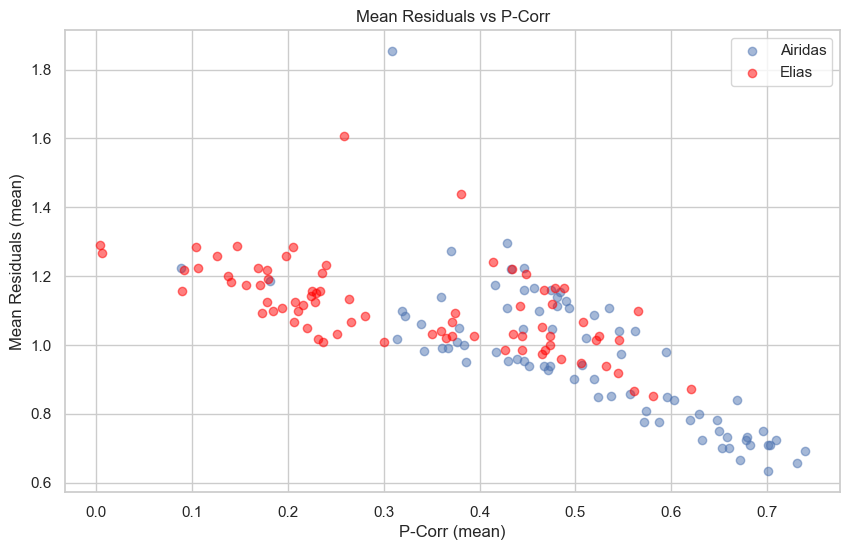

In [59]:
import matplotlib.pyplot as plt

# Assuming 'mean_residual_Airidas_mean' and 'p-corr_Airidas_mean' are already computed as mean values in your aggregated dataframe
# Plotting for Airidas
plt.figure(figsize=(10, 6))
plt.scatter(dfg['p-corr_Airidas_mean'], dfg['MAE_airi_mean'], label='Airidas', alpha=0.5)

# Assuming 'mean_residual_Elias_mean' and 'p-corr_Elias_mean' are also computed as mean values
# Plotting for Elias
plt.scatter(dfg['p-corr_Elias_mean'], dfg['MAE_eli_mean'], color='red', label='Elias', alpha=0.5)

plt.title('Mean Residuals vs P-Corr')
plt.xlabel('P-Corr (mean)')
plt.ylabel('Mean Residuals (mean)')
plt.legend()
plt.grid(True)
plt.show()